In [ ]:
from notebooks import *
print_sys_info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic
platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 21g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[15:56:52.235] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
recs_at_least, num_species, num_recs =  20, 168,  20    # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  50   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  20   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  10   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  5    # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          334/35236 (sp/recs)
(downloaded)       334/35232 (sp/recs)
recs_at_least      296/34846 (sp/recs)
num_species        168/19640 (sp/recs)


num_recs            168/3360 (sp/recs)
recs ≥ 2            168/3360 (sp/recs)


'sp[168], recs[3360]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,94080,3360,3360,1,NaN,NaN,True,True,True,True,True
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
id,int64,94080,3360,3360,3360,213283.439,108055.964,1133,138144,193564,308285,416744
sci_name,category,227200,3360,3360,168,NaN,NaN,Anser albifrons,Gelochelidon nilotica,Vireo olivaceus,Parkesia noveboracensis,Spinus tristis
com_name,category,220320,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
subspecies,object,169603,3360,3360,205,NaN,NaN,,,,,zaboria
recordist,object,211728,3360,3360,291,NaN,NaN,AJ Knue,Frank Lambert,Matthias Feuersenger,Peter Boesman,tetiaroa
country,object,203063,3360,3360,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,316516,3360,3360,1740,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Desert Beeline Highway, Maricopa County, Arizona","May Lake, Yosemite NP, California","Sabine Nature Trail loop, Cameron Parish, Louisiana","west of Thorp, WA"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
COGA,205189,True,COGA,207451,Gallinula galeata,Common Gallinule,sandvicensis,Ross Gallardy,United States,"Kailua, Honolulu County, Hawaii",21.4,-158.0,call,B,2014-12-21 00:00:00,07:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/207451,//www.xeno-canto.org/207451/download
INDO,18832,True,INDO,398616,Columbina inca,Inca Dove,,Manuel Grosselet,Mexico,Lomas de Bezares Miguel Hidalgo Mexico city,19.4,-99.2,song,B,2018-01-07 00:00:00,08:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/398616,//www.xeno-canto.org/398616/download
EWPW,223194,True,EWPW,188611,Antrostomus vociferus,Eastern Whip-poor-will,,David Jonas Weber,United States,"Gravelly Hill Rd., Salem County, New Jersey",39.5,-75.4,song,C,2014-07-25 00:00:00,05:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188611,//www.xeno-canto.org/188611/download
NUWO,113835,True,NUWO,301366,Picoides nuttallii,Nuttall's Woodpecker,,Denise Wight,United States,"Moraga, Contra Costa County, California",37.8,-122.0,"Hawk mobbing call, alarm call",C,2016-01-25 00:00:00,10:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/301366,//www.xeno-canto.org/301366/download
BBWO,80808,True,BBWO,335436,Picoides arcticus,Black-backed Woodpecker,,Lance A. M. Benner,United States,"Blackrock Trailhead, Tulare County, California",36.2,-118.0,"drumming, male",no score,2016-09-17 00:00:00,16:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/335436,//www.xeno-canto.org/335436/download
HUVI,117936,True,HUVI,297126,Vireo huttoni,Hutton's Vireo,,Paul Marvin,United States,"Kickapoo Cavern State Park, Brackettville, Texas",29.6,-100.0,song,C,2012-04-08 00:00:00,07:58,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/297126,//www.xeno-canto.org/297126/download
MGWA,89731,True,MGWA,326299,Geothlypis tolmiei,MacGillivray's Warbler,,Lance A. M. Benner,United States,"Buckhorn Campground, San Gabriel Mountains, Los Angeles County, California",34.3,-118.0,"male, song",no score,2016-06-28 00:00:00,10:49,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/326299,//www.xeno-canto.org/326299/download
PUFI,159786,True,PUFI,254326,Haemorhous purpureus,Purple Finch,,Iain,Canada,"Algonquin Highlands, Haliburton County, Ontario",45.3,-78.8,song,C,2015-06-27 00:00:00,11:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/254326,//www.xeno-canto.org/254326/download
CAFI,46804,True,CAFI,369971,Haemorhous cassinii,Cassin's Finch,,Eric DeFonso,United States,"Dunton Rd area, San Juan National Forest, Dolores County, Colorado",37.8,-108.0,song,A,2016-06-28 00:00:00,15:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/369971,//www.xeno-canto.org/369971/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    # xcs_paths[:2],
)

3360

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,171360,3360,3360,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
species_com_name,category,219160,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
species_query,object,178080,3360,3360,168,NaN,NaN,ACWO,CONI,LASP,RIRA,YRWA
duration_s,float64,80640,3360,3360,3054,5.430e+01,7.031e+01,0.697,14.4,31.8,65.4,940
samples_mb,float64,80640,3360,3360,3055,2.286e+00,2.958e+00,0.0293,0.604,1.34,2.76,39.5
samples_n,int64,94080,3360,3360,3055,1.198e+06,1.551e+06,15368,316510,701190,1444435,20731931
basename,object,181440,3360,3360,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,242680,3360,3360,168,NaN,NaN,Greater White-fronted Goose - GWFG,Gull-billed Tern - GBTE,Red-eyed Vireo - REVI,Northern Waterthrush - NOWA,American Goldfinch - AMGO


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Greater White-fronted Goose - GWFG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1,Gadwall - GADW,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,American Wigeon - AMWI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Mallard - MALL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Green-winged Teal - GWTE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5,California Quail - CAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Sooty Grouse - SOGR,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Wild Turkey - WITU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Common Loon - COLO,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = list(unique_everseen([
    dict(
        classifier=[classifier],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        (1.00, 1.00),
        (1.00, 0.50),
        (0.50, 1.00),

        # (0.10, 0.10),  # Faster dev

    ]
    # model_size ~ forest_depth
    for rf_mean_depth_at_168_sp in [93.5]
    for rf_max_depth in [
        'null',
        int(rf_mean_depth_at_168_sp * n_species * 1),
        int(rf_mean_depth_at_168_sp * n_species * 3/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/2),
        int(rf_mean_depth_at_168_sp * n_species * 1/3),
        int(rf_mean_depth_at_168_sp * n_species * 1/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/8),
        5,
        4,
        3,
        2,
        1,
    ]
    # for ovr_rf_max_depth in [int(rf_max_depth / 10) if rf_max_depth != 'null' else 'null']
    # for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    for ovr_rf_max_depth in [
        'null',
        46,
        5,
        4,
        3,
        2,
        1,
    ]
    for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    for classifier in [

        # WARNING These two are not mem safe locally
        #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
        # 'cls: rf, n_estimators: 2000',
        # 'cls: rf, n_estimators: 1500',

        f'cls: xgbm, n_estimators: 100, max_depth: {xgb_rf_max_depth(rf_max_depth)}',
        f'cls: xgbm, n_estimators: 100, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        f'cls: xgbm, n_estimators: 50, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        f'cls: xgbm, n_estimators: 25, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        f'cls: rf, n_estimators: 100, max_depth: {rf_max_depth}',
        f'cls: rf, n_estimators: 100, max_depth: {rf_max_depth}',
        f'cls: rf, n_estimators: 100, max_depth: {rf_max_depth}',
        f'cls: ovr-rf, n_estimators: 100, max_depth: {ovr_rf_max_depth}',
        f'cls: ovr-rf, n_estimators: 50, max_depth: {ovr_rf_max_depth}',
        f'cls: ovr-rf, n_estimators: 25, max_depth: {ovr_rf_max_depth}',

    ]
]))

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # recompute_extra_metrics=True,  # Loads estimator.pkl (fast) but doesn't return it (huge)
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    # n_jobs=1,  # For %prun, and way faster for 100% loads
    n_jobs=2,
    # n_jobs=4,
    # n_jobs=8,  # For slow ovr serdes [why?]
    # n_jobs=16,  # For recomputing model_stats
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        save=True,
        reuse='20180709-211727-fd34af5-ovr_try_2',
        # skip_compute_if_missing=True,  # TODO Tricky to implement: _fit_and_score_cached needs to be able to return nothing
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, fold, params_data, params_complexity, params_model, ...
params_data = [
    'n_species',
    'n_recs',
]
params_complexity = [
    'c_max_depth',
    # 'c_C',
]
# params_model = ...  # Everything else
# log.debug('Start')
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params (for validation curves, learning curves, etc.)
    .assign(
        params_data=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in params_data if k in d
        )),
        params_complexity=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in params_complexity if k in d
        )),
        params_model=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in params_data + params_complexity
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        params_data=lambda df: df.params_data.unique(),
        # Order params_complexity like c_max_depth
        params_complexity=lambda df: sorted(
            df.params_complexity.unique(),
            reverse=True,  # Match how the normal .unique() would come out (not clear why, and don't care)
            key=lambda s: one(
                or_else(-np.inf, lambda: float({'None': 'inf'}.get(x_str, x_str)))
                for x_str in [strip_endswith(strip_startswith(s, 'c_max_depth['), ']')]
            ),
        ),
        params_model=lambda df: df.params_model.unique(),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
    )
    # .pipe(tap, f=lambda df: log.debug('SearchEvals.score'))
    .assign(
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),  # (= 50p)
        test_75p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=75))),
        test_95p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=95))),
        # train_score=lambda df: map_progress(lambda x: x.score(), df.train_evals, use='dask', scheduler='threads'),
        # test_score=lambda df: map_progress(lambda x: x.score(), df.test_evals, use='dask', scheduler='threads'),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    # .pipe(tap, f=lambda df: log.debug('proc_stats'))
    .pipe(lambda df: df.join(df
        .apply(axis=1, func=lambda row: (row.proc_stats.stats
            .groupby('pid')[['cpu_user', 'cpu_system', 'mem_rss', 'mem_vms']].agg(lambda g: g.max() - g.min())
            .sum(axis=0)
        ))
        .rename(columns={
            'cpu_user': 'cpu_user_time',
            'cpu_system': 'cpu_system_time',
            'mem_rss': 'mem_rss_delta',
            'mem_vms': 'mem_vms_delta',
        })
    ))
    .assign(
        cpu_time=lambda df: df.cpu_user_time + df.cpu_system_time,
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_data', 'params_complexity', 'params_model'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    # .pipe(tap, f=lambda df: log.debug('display'))
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df,
        len(df),
        df[:5],
    ))
    # .pipe(tap, f=lambda df: log.debug('Done'))
)

Fitting 3 folds for each of 175 candidates, totalling 525 fits
[15:56:58.441] INFO   artifacts
  dir: /Users/danb/hack/bubo/features/data/artifacts
  save: true
  reuse: 20180709-211727-fd34af5-ovr_try_2
  experiment_id: 20180709-211727-fd34af5-ovr_try_2


[15:56:58.709] INFO   _fit_and_score: n[1/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.015s, 4.7 MB]: ret


[15:56:58.718] INFO   _fit_and_score: n[2/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.016s, 4.7 MB]: ret


[15:56:58.767] INFO   _fit_and_score: n[3/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.012s, 4.8 MB]: ret


[15:56:58.815] INFO   _fit_and_score: n[4/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.007s, 3.5 MB]: ret


[15:56:58.864] INFO   _fit_and_score: n[5/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.007s, 3.5 MB]: ret


[15:56:58.873] INFO   _fit_and_score: n[6/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.006s, 3.5 MB]: ret


[15:56:58.900] INFO   _fit_and_score: n[7/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.006s, 2.9 MB]: ret


[15:56:58.909] INFO   _fit_and_score: n[8/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.005s, 2.9 MB]: ret


[15:56:58.973] INFO   _fit_and_score: n[9/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.008s, 2.9 MB]: ret


[15:56:58.981] INFO   _fit_and_score: n[10/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.005s, 4.7 MB]: ret


[15:56:59.046] INFO   _fit_and_score: n[11/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.005s, 4.7 MB]: ret


[15:56:59.058] INFO   _fit_and_score: n[12/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[15:56:59.372] INFO   _fit_and_score: n[13/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.012s, 9.3 MB]: ret


[15:56:59.389] INFO   _fit_and_score: n[14/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.015s, 9.4 MB]: ret


[15:57:01.055] INFO   _fit_and_score: n[15/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.013s, 9.4 MB]: ret


[15:57:01.066] INFO   _fit_and_score: n[16/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.009s, 7.0 MB]: ret


[15:57:02.923] INFO   _fit_and_score: n[17/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.009s, 7.0 MB]: ret


[15:57:02.936] INFO   _fit_and_score: n[18/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.011s, 7.0 MB]: ret


[15:57:04.643] INFO   _fit_and_score: n[19/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.007s, 5.8 MB]: ret


[15:57:04.654] INFO   _fit_and_score: n[20/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.008s, 5.8 MB]: ret


[15:57:06.674] INFO   _fit_and_score: n[21/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.007s, 5.8 MB]: ret


[15:57:06.686] INFO   _fit_and_score: n[22/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.009s, 4.7 MB]: ret


[15:57:11.029] INFO   _fit_and_score: n[23/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[15:57:11.426] INFO   _fit_and_score: n[24/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.009s, 4.8 MB]: ret


[15:57:11.473] INFO   _fit_and_score: n[25/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.008s, 3.5 MB]: ret


[15:57:11.525] INFO   _fit_and_score: n[26/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.007s, 3.5 MB]: ret


[15:57:11.567] INFO   _fit_and_score: n[27/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.007s, 3.5 MB]: ret


[15:57:11.601] INFO   _fit_and_score: n[28/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.005s, 2.9 MB]: ret


[15:57:11.649] INFO   _fit_and_score: n[29/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.007s, 2.9 MB]: ret


[15:57:11.688] INFO   _fit_and_score: n[30/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.006s, 2.9 MB]: ret


[15:57:11.730] INFO   _fit_and_score: n[31/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.015s, 9.2 MB]: ret


[15:57:11.775] INFO   _fit_and_score: n[32/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.018s, 9.2 MB]: ret


[15:57:11.876] INFO   _fit_and_score: n[33/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.012s, 9.2 MB]: ret


[15:57:12.055] INFO   _fit_and_score: n[34/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.009s, 6.9 MB]: ret


[15:57:12.167] INFO   _fit_and_score: n[35/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.009s, 6.9 MB]: ret


[15:57:12.251] INFO   _fit_and_score: n[36/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.009s, 6.9 MB]: ret


[15:57:12.316] INFO   _fit_and_score: n[37/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.008s, 5.8 MB]: ret


[15:57:12.377] INFO   _fit_and_score: n[38/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.007s, 5.8 MB]: ret


[15:57:12.433] INFO   _fit_and_score: n[39/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.007s, 5.8 MB]: ret


[15:57:12.494] INFO   _fit_and_score: n[40/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.011s, 4.6 MB]: ret


[15:57:12.551] INFO   _fit_and_score: n[41/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.009s, 4.6 MB]: ret


[15:57:12.591] INFO   _fit_and_score: n[42/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.011s, 4.6 MB]: ret


[15:57:12.631] INFO   _fit_and_score: n[43/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.008s, 3.5 MB]: ret


[15:57:12.680] INFO   _fit_and_score: n[44/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.008s, 3.5 MB]: ret


[15:57:12.719] INFO   _fit_and_score: n[45/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.008s, 3.5 MB]: ret


[15:57:12.753] INFO   _fit_and_score: n[46/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.006s, 2.9 MB]: ret


[15:57:12.796] INFO   _fit_and_score: n[47/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.006s, 2.9 MB]: ret


[15:57:12.834] INFO   _fit_and_score: n[48/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.006s, 2.9 MB]: ret


[15:57:12.885] INFO   _fit_and_score: n[49/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.017s, 9.2 MB]: ret


[15:57:12.938] INFO   _fit_and_score: n[50/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.020s, 9.2 MB]: ret


[15:57:13.026] INFO   _fit_and_score: n[51/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.014s, 9.2 MB]: ret


[15:57:13.096] INFO   _fit_and_score: n[52/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.009s, 6.9 MB]: ret


[15:57:13.237] INFO   _fit_and_score: n[53/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.009s, 6.9 MB]: ret


[15:57:13.328] INFO   _fit_and_score: n[54/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.009s, 6.9 MB]: ret


[15:57:13.393] INFO   _fit_and_score: n[55/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.009s, 5.8 MB]: ret


[15:57:13.453] INFO   _fit_and_score: n[56/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.010s, 5.8 MB]: ret


[15:57:13.517] INFO   _fit_and_score: n[57/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.017s, 5.8 MB]: ret


[15:57:13.580] INFO   _fit_and_score: n[58/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[15:57:13.636] INFO   _fit_and_score: n[59/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.011s, 4.7 MB]: ret


[15:57:13.681] INFO   _fit_and_score: n[60/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[Parallel(n_jobs=2)]: Done  55 tasks      | elapsed:   14.9s


[15:57:13.729] INFO   _fit_and_score: n[61/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.010s, 3.5 MB]: ret


[15:57:13.781] INFO   _fit_and_score: n[62/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:57:13.835] INFO   _fit_and_score: n[63/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.010s, 3.5 MB]: ret


[15:57:13.879] INFO   _fit_and_score: n[64/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:57:13.924] INFO   _fit_and_score: n[65/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.006s, 2.9 MB]: ret


[15:57:13.968] INFO   _fit_and_score: n[66/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.008s, 3.0 MB]: ret


[15:57:14.032] INFO   _fit_and_score: n[67/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.020s, 9.2 MB]: ret


[15:57:14.091] INFO   _fit_and_score: n[68/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.027s, 9.2 MB]: ret


[15:57:14.183] INFO   _fit_and_score: n[69/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.017s, 9.2 MB]: ret


[15:57:14.273] INFO   _fit_and_score: n[70/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.010s, 6.9 MB]: ret


[15:57:14.355] INFO   _fit_and_score: n[71/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.012s, 6.9 MB]: ret


[15:57:14.435] INFO   _fit_and_score: n[72/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.010s, 6.9 MB]: ret


[15:57:14.500] INFO   _fit_and_score: n[73/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.008s, 5.8 MB]: ret


[15:57:14.571] INFO   _fit_and_score: n[74/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.012s, 5.8 MB]: ret


[15:57:14.638] INFO   _fit_and_score: n[75/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.009s, 5.8 MB]: ret


[15:57:14.706] INFO   _fit_and_score: n[76/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.014s, 4.7 MB]: ret


[15:57:14.769] INFO   _fit_and_score: n[77/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.011s, 4.7 MB]: ret


[15:57:14.818] INFO   _fit_and_score: n[78/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.017s, 4.7 MB]: ret


[15:57:14.865] INFO   _fit_and_score: n[79/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:57:14.918] INFO   _fit_and_score: n[80/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.009s, 3.5 MB]: ret


[15:57:14.958] INFO   _fit_and_score: n[81/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.010s, 3.5 MB]: ret


[15:57:15.005] INFO   _fit_and_score: n[82/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.008s, 2.9 MB]: ret


[15:57:15.054] INFO   _fit_and_score: n[83/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.008s, 2.9 MB]: ret


[15:57:15.096] INFO   _fit_and_score: n[84/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:57:15.149] INFO   _fit_and_score: n[85/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.016s, 9.2 MB]: ret


[15:57:15.202] INFO   _fit_and_score: n[86/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.028s, 9.2 MB]: ret


[15:57:15.309] INFO   _fit_and_score: n[87/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.015s, 9.2 MB]: ret


[15:57:15.531] INFO   _fit_and_score: n[88/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.013s, 6.9 MB]: ret


[15:57:15.718] INFO   _fit_and_score: n[89/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.010s, 6.9 MB]: ret


[15:57:15.841] INFO   _fit_and_score: n[90/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.011s, 6.9 MB]: ret


[15:57:15.903] INFO   _fit_and_score: n[91/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.011s, 5.8 MB]: ret


[15:57:16.471] INFO   _fit_and_score: n[92/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.010s, 5.8 MB]: ret


[15:57:16.524] INFO   _fit_and_score: n[93/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.015s, 5.8 MB]: ret


[15:57:16.588] INFO   _fit_and_score: n[94/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.011s, 4.7 MB]: ret


[15:57:16.653] INFO   _fit_and_score: n[95/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.011s, 4.7 MB]: ret


[15:57:16.704] INFO   _fit_and_score: n[96/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.018s, 4.7 MB]: ret


[15:57:16.754] INFO   _fit_and_score: n[97/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:57:16.807] INFO   _fit_and_score: n[98/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.009s, 3.5 MB]: ret


[15:57:16.851] INFO   _fit_and_score: n[99/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.014s, 3.5 MB]: ret


[15:57:16.903] INFO   _fit_and_score: n[100/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.009s, 2.9 MB]: ret


[15:57:16.945] INFO   _fit_and_score: n[101/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:57:16.979] INFO   _fit_and_score: n[102/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.007s, 2.9 MB]: ret


[15:57:17.036] INFO   _fit_and_score: n[103/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.021s, 9.1 MB]: ret


[15:57:17.081] INFO   _fit_and_score: n[104/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.023s, 9.2 MB]: ret


[15:57:17.166] INFO   _fit_and_score: n[105/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.020s, 9.1 MB]: ret


[15:57:17.330] INFO   _fit_and_score: n[106/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.011s, 6.9 MB]: ret


[15:57:17.512] INFO   _fit_and_score: n[107/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.014s, 6.9 MB]: ret


[15:57:17.576] INFO   _fit_and_score: n[108/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.010s, 6.9 MB]: ret


[15:57:17.641] INFO   _fit_and_score: n[109/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.010s, 5.8 MB]: ret


[15:57:17.709] INFO   _fit_and_score: n[110/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.008s, 5.8 MB]: ret


[15:57:17.778] INFO   _fit_and_score: n[111/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.009s, 5.8 MB]: ret


[15:57:17.837] INFO   _fit_and_score: n[112/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[15:57:17.900] INFO   _fit_and_score: n[113/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[15:57:17.953] INFO   _fit_and_score: n[114/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.014s, 4.7 MB]: ret


[15:57:17.999] INFO   _fit_and_score: n[115/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:57:18.057] INFO   _fit_and_score: n[116/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.008s, 3.5 MB]: ret


[15:57:18.095] INFO   _fit_and_score: n[117/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.010s, 3.5 MB]: ret


[15:57:18.145] INFO   _fit_and_score: n[118/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:57:18.188] INFO   _fit_and_score: n[119/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:57:18.221] INFO   _fit_and_score: n[120/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.006s, 2.9 MB]: ret


[15:57:18.274] INFO   _fit_and_score: n[121/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.018s, 9.1 MB]: ret


[15:57:18.322] INFO   _fit_and_score: n[122/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.015s, 9.1 MB]: ret


[15:57:18.418] INFO   _fit_and_score: n[123/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.019s, 9.1 MB]: ret


[15:57:18.575] INFO   _fit_and_score: n[124/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.010s, 6.9 MB]: ret


[15:57:18.588] INFO   _fit_and_score: n[125/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.010s, 6.9 MB]: ret


[15:57:18.763] INFO   _fit_and_score: n[126/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.011s, 6.9 MB]: ret


[15:57:18.774] INFO   _fit_and_score: n[127/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.009s, 5.8 MB]: ret


[15:57:19.546] INFO   _fit_and_score: n[128/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.008s, 5.8 MB]: ret


[15:57:19.557] INFO   _fit_and_score: n[129/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.009s, 5.8 MB]: ret


[15:57:19.941] INFO   _fit_and_score: n[130/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.011s, 4.7 MB]: ret


[15:57:19.956] INFO   _fit_and_score: n[131/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.012s, 4.8 MB]: ret


[15:57:20.622] INFO   _fit_and_score: n[132/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.010s, 4.8 MB]: ret


[15:57:20.630] INFO   _fit_and_score: n[133/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.006s, 4.7 MB]: ret


[15:57:20.786] INFO   _fit_and_score: n[134/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.008s, 4.7 MB]: ret


[15:57:20.795] INFO   _fit_and_score: n[135/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.006s, 4.6 MB]: ret


[15:57:21.036] INFO   _fit_and_score: n[136/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.009s, 4.7 MB]: ret


[15:57:21.048] INFO   _fit_and_score: n[137/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.010s, 4.8 MB]: ret


[15:57:21.188] INFO   _fit_and_score: n[138/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.009s, 4.7 MB]: ret


[15:57:21.196] INFO   _fit_and_score: n[139/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.006s, 4.6 MB]: ret


[15:57:21.342] INFO   _fit_and_score: n[140/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.007s, 4.6 MB]: ret


[15:57:21.351] INFO   _fit_and_score: n[141/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.006s, 4.6 MB]: ret


[15:57:21.594] INFO   _fit_and_score: n[142/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.007s, 4.6 MB]: ret


[15:57:21.604] INFO   _fit_and_score: n[143/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.007s, 4.6 MB]: ret


[15:57:21.952] INFO   _fit_and_score: n[144/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.006s, 4.6 MB]: ret


[15:57:21.965] INFO   _fit_and_score: n[145/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[15:57:22.904] INFO   _fit_and_score: n[146/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.011s, 4.7 MB]: ret


[15:57:22.917] INFO   _fit_and_score: n[147/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.010s, 4.8 MB]: ret


[15:57:25.432] INFO   _fit_and_score: n[148/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.006s, 4.6 MB]: ret


[15:57:25.440] INFO   _fit_and_score: n[149/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.005s, 4.6 MB]: ret


[15:57:26.912] INFO   _fit_and_score: n[150/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.006s, 4.6 MB]: ret


[15:57:26.924] INFO   _fit_and_score: n[151/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.009s, 4.8 MB]: ret


[15:57:30.571] INFO   _fit_and_score: n[152/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.010s, 4.8 MB]: ret


[15:57:30.583] INFO   _fit_and_score: n[153/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.010s, 4.7 MB]: ret


[15:57:30.907] INFO   _fit_and_score: n[154/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.005s, 4.6 MB]: ret


[15:57:30.984] INFO   _fit_and_score: n[155/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.006s, 4.6 MB]: ret


[15:57:31.191] INFO   _fit_and_score: n[156/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.008s, 4.6 MB]: ret


[15:57:31.253] INFO   _fit_and_score: n[157/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.011s, 4.7 MB]: ret


[15:57:31.323] INFO   _fit_and_score: n[158/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.019s, 4.7 MB]: ret


[15:57:31.372] INFO   _fit_and_score: n[159/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.013s, 4.7 MB]: ret


[15:57:31.424] INFO   _fit_and_score: n[160/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.008s, 4.6 MB]: ret


[15:57:31.466] INFO   _fit_and_score: n[161/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.009s, 4.6 MB]: ret


[15:57:31.539] INFO   _fit_and_score: n[162/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.007s, 4.6 MB]: ret


[15:57:31.594] INFO   _fit_and_score: n[163/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit...


[15:57:31.662] INFO   _fit_and_score: n[164/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit...


[15:57:35.892] INFO   _fit_and_score: n[163/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit[4.053s]


[15:57:35.970] INFO   _fit_and_score: n[164/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit[4.069s]


[15:57:36.897] INFO   _fit_and_score: n[163/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:36.973] INFO   _fit_and_score: n[164/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:37.297] INFO   _fit_and_score: n[164/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics[0.314s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:37.299] INFO   _fit_and_score: n[164/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: ret...


[15:57:37.307] INFO   _fit_and_score: n[163/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics[0.400s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:37.309] INFO   _fit_and_score: n[163/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: ret...


[15:57:37.327] INFO   _fit_and_score: n[164/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.026s, 4.6 MB]: ret


[15:57:37.329] INFO   _fit_and_score: n[164/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: estimator...


[15:57:37.334] INFO   _fit_and_score: n[163/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.023s, 4.6 MB]: ret


[15:57:37.337] INFO   _fit_and_score: n[163/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: estimator...


[15:57:37.445] INFO   _fit_and_score: n[164/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.114s, 21.5 MB]: estimator


[15:57:37.465] INFO   _fit_and_score: n[163/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.125s, 21.5 MB]: estimator


[15:57:37.547] INFO   _fit_and_score: n[165/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit...


[15:57:37.609] INFO   _fit_and_score: n[166/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:57:41.205] INFO   _fit_and_score: n[166/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[3.413s]


[15:57:41.397] INFO   _fit_and_score: n[165/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit[3.652s]


[15:57:41.803] INFO   _fit_and_score: n[165/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:41.857] INFO   _fit_and_score: n[166/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:42.204] INFO   _fit_and_score: n[165/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics[0.394s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:42.206] INFO   _fit_and_score: n[165/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: ret...


[15:57:42.225] INFO   _fit_and_score: n[165/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.018s, 4.6 MB]: ret


[15:57:42.228] INFO   _fit_and_score: n[165/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: estimator...


[15:57:42.274] INFO   _fit_and_score: n[166/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.404s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:42.276] INFO   _fit_and_score: n[166/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:57:42.290] INFO   _fit_and_score: n[166/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:57:42.292] INFO   _fit_and_score: n[166/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:57:42.332] INFO   _fit_and_score: n[165/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.102s, 21.6 MB]: estimator


[15:57:42.385] INFO   _fit_and_score: n[166/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.090s, 19.6 MB]: estimator


[15:57:42.448] INFO   _fit_and_score: n[167/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:57:42.505] INFO   _fit_and_score: n[168/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:57:45.792] INFO   _fit_and_score: n[167/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[3.158s]


[15:57:45.894] INFO   _fit_and_score: n[168/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[3.211s]


[15:57:46.695] INFO   _fit_and_score: n[167/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:46.760] INFO   _fit_and_score: n[168/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:46.990] INFO   _fit_and_score: n[167/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.286s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:46.992] INFO   _fit_and_score: n[167/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:57:47.009] INFO   _fit_and_score: n[167/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.015s, 4.6 MB]: ret


[15:57:47.012] INFO   _fit_and_score: n[167/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:57:47.093] INFO   _fit_and_score: n[167/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.079s, 19.6 MB]: estimator


[15:57:47.166] INFO   _fit_and_score: n[168/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.397s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:47.166] INFO   _fit_and_score: n[169/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:57:47.169] INFO   _fit_and_score: n[168/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:57:47.186] INFO   _fit_and_score: n[168/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.015s, 4.6 MB]: ret


[15:57:47.189] INFO   _fit_and_score: n[168/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:57:47.273] INFO   _fit_and_score: n[168/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.083s, 19.6 MB]: estimator


[15:57:47.349] INFO   _fit_and_score: n[170/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:57:49.742] INFO   _fit_and_score: n[169/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[2.388s]


[15:57:49.984] INFO   _fit_and_score: n[170/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[2.477s]


[15:57:50.402] INFO   _fit_and_score: n[169/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:50.550] INFO   _fit_and_score: n[170/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:50.698] INFO   _fit_and_score: n[169/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.287s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:50.700] INFO   _fit_and_score: n[169/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:57:50.715] INFO   _fit_and_score: n[169/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.014s, 4.6 MB]: ret


[15:57:50.717] INFO   _fit_and_score: n[169/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:57:50.797] INFO   _fit_and_score: n[169/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.079s, 18.3 MB]: estimator


[15:57:50.850] INFO   _fit_and_score: n[170/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.292s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:50.852] INFO   _fit_and_score: n[170/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:57:50.868] INFO   _fit_and_score: n[170/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.014s, 4.6 MB]: ret


[15:57:50.869] INFO   _fit_and_score: n[170/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:57:50.892] INFO   _fit_and_score: n[171/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:57:50.954] INFO   _fit_and_score: n[170/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.083s, 18.2 MB]: estimator


[15:57:51.040] INFO   _fit_and_score: n[172/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:57:53.376] INFO   _fit_and_score: n[172/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[2.177s]


[15:57:53.531] INFO   _fit_and_score: n[171/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[2.444s]


[15:57:54.127] INFO   _fit_and_score: n[171/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:54.237] INFO   _fit_and_score: n[172/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:54.427] INFO   _fit_and_score: n[171/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.292s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:54.430] INFO   _fit_and_score: n[171/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:57:54.443] INFO   _fit_and_score: n[171/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:57:54.446] INFO   _fit_and_score: n[171/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:57:54.526] INFO   _fit_and_score: n[171/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.079s, 18.3 MB]: estimator


[15:57:54.547] INFO   _fit_and_score: n[172/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.300s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:54.549] INFO   _fit_and_score: n[172/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:57:54.564] INFO   _fit_and_score: n[172/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.014s, 4.6 MB]: ret


[15:57:54.566] INFO   _fit_and_score: n[172/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:57:54.632] INFO   _fit_and_score: n[173/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:57:54.637] INFO   _fit_and_score: n[172/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.069s, 17.3 MB]: estimator


[15:57:54.717] INFO   _fit_and_score: n[174/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:57:56.760] INFO   _fit_and_score: n[173/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[1.964s]


[15:57:56.837] INFO   _fit_and_score: n[173/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:57.020] INFO   _fit_and_score: n[174/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[2.151s]


[15:57:57.131] INFO   _fit_and_score: n[173/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.282s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:57.133] INFO   _fit_and_score: n[173/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:57:57.146] INFO   _fit_and_score: n[173/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:57:57.147] INFO   _fit_and_score: n[173/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:57:57.214] INFO   _fit_and_score: n[173/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.065s, 17.3 MB]: estimator


[15:57:57.281] INFO   _fit_and_score: n[175/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[15:57:57.924] INFO   _fit_and_score: n[174/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:58.415] INFO   _fit_and_score: n[174/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.477s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:58.417] INFO   _fit_and_score: n[174/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:57:58.419] INFO   _fit_and_score: n[175/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[0.998s]


[15:57:58.431] INFO   _fit_and_score: n[174/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:57:58.433] INFO   _fit_and_score: n[174/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:57:58.448] INFO   _fit_and_score: n[175/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:58.532] INFO   _fit_and_score: n[174/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.097s, 17.3 MB]: estimator


[15:57:58.618] INFO   _fit_and_score: n[176/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[15:57:58.736] INFO   _fit_and_score: n[175/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.279s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:57:58.738] INFO   _fit_and_score: n[175/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:57:58.753] INFO   _fit_and_score: n[175/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.013s, 4.6 MB]: ret


[15:57:58.755] INFO   _fit_and_score: n[175/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:57:58.831] INFO   _fit_and_score: n[175/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.075s, 16.8 MB]: estimator


[15:57:58.908] INFO   _fit_and_score: n[177/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[15:57:59.851] INFO   _fit_and_score: n[176/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[1.084s]


[15:58:00.334] INFO   _fit_and_score: n[177/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[1.261s]


[15:58:00.802] INFO   _fit_and_score: n[176/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:01.091] INFO   _fit_and_score: n[176/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.280s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:01.092] INFO   _fit_and_score: n[176/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:58:01.105] INFO   _fit_and_score: n[177/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:01.106] INFO   _fit_and_score: n[176/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.013s, 4.6 MB]: ret


[15:58:01.108] INFO   _fit_and_score: n[176/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:58:01.208] INFO   _fit_and_score: n[176/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.098s, 16.8 MB]: estimator


[15:58:01.316] INFO   _fit_and_score: n[178/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.018s, 4.7 MB]: ret


[15:58:01.396] INFO   _fit_and_score: n[177/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.282s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:01.398] INFO   _fit_and_score: n[177/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:58:01.401] INFO   _fit_and_score: n[179/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.018s, 4.7 MB]: ret


[15:58:01.413] INFO   _fit_and_score: n[177/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.013s, 4.6 MB]: ret


[15:58:01.414] INFO   _fit_and_score: n[177/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:58:01.479] INFO   _fit_and_score: n[180/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.014s, 4.7 MB]: ret


[15:58:01.492] INFO   _fit_and_score: n[177/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.076s, 16.8 MB]: estimator


[15:58:01.555] INFO   _fit_and_score: n[181/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.016s, 3.5 MB]: ret


[15:58:01.607] INFO   _fit_and_score: n[182/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.017s, 3.5 MB]: ret


[15:58:01.662] INFO   _fit_and_score: n[183/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:58:01.704] INFO   _fit_and_score: n[184/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.013s, 2.9 MB]: ret


[15:58:01.735] INFO   _fit_and_score: n[185/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.013s, 2.9 MB]: ret


[15:58:01.780] INFO   _fit_and_score: n[186/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.012s, 2.9 MB]: ret


[15:58:01.820] INFO   _fit_and_score: n[187/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.010s, 4.6 MB]: ret


[15:58:01.876] INFO   _fit_and_score: n[188/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:01.924] INFO   _fit_and_score: n[189/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.012s, 4.6 MB]: ret


[15:58:01.986] INFO   _fit_and_score: n[190/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.025s, 9.1 MB]: ret


[15:58:02.049] INFO   _fit_and_score: n[191/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.026s, 9.1 MB]: ret


[15:58:02.134] INFO   _fit_and_score: n[192/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.024s, 9.1 MB]: ret


[15:58:02.243] INFO   _fit_and_score: n[193/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.017s, 6.9 MB]: ret


[15:58:02.855] INFO   _fit_and_score: n[194/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.019s, 6.9 MB]: ret


[15:58:03.050] INFO   _fit_and_score: n[195/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.017s, 6.9 MB]: ret


[15:58:03.111] INFO   _fit_and_score: n[196/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:03.180] INFO   _fit_and_score: n[197/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.014s, 5.8 MB]: ret


[15:58:03.252] INFO   _fit_and_score: n[198/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:03.420] INFO   _fit_and_score: n[199/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.027s, 4.7 MB]: ret


[15:58:03.518] INFO   _fit_and_score: n[200/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.021s, 4.7 MB]: ret


[15:58:03.565] INFO   _fit_and_score: n[201/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.017s, 4.7 MB]: ret


[15:58:03.620] INFO   _fit_and_score: n[202/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.015s, 3.5 MB]: ret


[15:58:03.670] INFO   _fit_and_score: n[203/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.015s, 3.5 MB]: ret


[15:58:03.714] INFO   _fit_and_score: n[204/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:58:03.752] INFO   _fit_and_score: n[205/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.012s, 2.9 MB]: ret


[15:58:03.793] INFO   _fit_and_score: n[206/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.012s, 2.9 MB]: ret


[15:58:03.829] INFO   _fit_and_score: n[207/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:03.883] INFO   _fit_and_score: n[208/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.025s, 9.2 MB]: ret


[15:58:03.940] INFO   _fit_and_score: n[209/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.024s, 9.2 MB]: ret


[15:58:04.028] INFO   _fit_and_score: n[210/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.025s, 9.2 MB]: ret


[15:58:04.102] INFO   _fit_and_score: n[211/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.017s, 6.9 MB]: ret


[15:58:04.690] INFO   _fit_and_score: n[212/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.018s, 6.9 MB]: ret


[15:58:04.936] INFO   _fit_and_score: n[213/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.017s, 6.9 MB]: ret


[15:58:05.015] INFO   _fit_and_score: n[214/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.017s, 5.8 MB]: ret


[15:58:05.105] INFO   _fit_and_score: n[215/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:05.171] INFO   _fit_and_score: n[216/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:05.238] INFO   _fit_and_score: n[217/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.016s, 4.7 MB]: ret


[15:58:05.309] INFO   _fit_and_score: n[218/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.017s, 4.7 MB]: ret


[15:58:05.357] INFO   _fit_and_score: n[219/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.017s, 4.7 MB]: ret


[15:58:05.401] INFO   _fit_and_score: n[220/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:05.482] INFO   _fit_and_score: n[221/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.046s, 3.5 MB]: ret


[15:58:05.598] INFO   _fit_and_score: n[222/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.016s, 3.5 MB]: ret


[15:58:05.666] INFO   _fit_and_score: n[223/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:05.713] INFO   _fit_and_score: n[224/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:05.757] INFO   _fit_and_score: n[225/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[Parallel(n_jobs=2)]: Done 220 tasks      | elapsed:  1.1min


[15:58:05.812] INFO   _fit_and_score: n[226/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.026s, 9.1 MB]: ret


[15:58:05.870] INFO   _fit_and_score: n[227/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.036s, 9.1 MB]: ret


[15:58:05.961] INFO   _fit_and_score: n[228/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.024s, 9.1 MB]: ret


[15:58:06.056] INFO   _fit_and_score: n[229/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.016s, 6.9 MB]: ret


[15:58:06.204] INFO   _fit_and_score: n[230/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.019s, 6.9 MB]: ret


[15:58:06.313] INFO   _fit_and_score: n[231/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.020s, 6.9 MB]: ret


[15:58:06.381] INFO   _fit_and_score: n[232/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:06.501] INFO   _fit_and_score: n[233/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.014s, 5.8 MB]: ret


[15:58:06.570] INFO   _fit_and_score: n[234/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.013s, 5.8 MB]: ret


[15:58:06.642] INFO   _fit_and_score: n[235/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.014s, 4.7 MB]: ret


[15:58:06.715] INFO   _fit_and_score: n[236/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.014s, 4.7 MB]: ret


[15:58:06.770] INFO   _fit_and_score: n[237/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.014s, 4.7 MB]: ret


[15:58:06.823] INFO   _fit_and_score: n[238/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:06.874] INFO   _fit_and_score: n[239/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:06.919] INFO   _fit_and_score: n[240/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:06.965] INFO   _fit_and_score: n[241/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:07.015] INFO   _fit_and_score: n[242/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:07.057] INFO   _fit_and_score: n[243/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.013s, 2.9 MB]: ret


[15:58:07.116] INFO   _fit_and_score: n[244/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.026s, 9.1 MB]: ret


[15:58:07.164] INFO   _fit_and_score: n[245/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.026s, 9.1 MB]: ret


[15:58:07.263] INFO   _fit_and_score: n[246/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.024s, 9.1 MB]: ret


[15:58:07.421] INFO   _fit_and_score: n[247/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.025s, 6.9 MB]: ret


[15:58:07.599] INFO   _fit_and_score: n[248/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.015s, 6.9 MB]: ret


[15:58:07.696] INFO   _fit_and_score: n[249/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.016s, 6.9 MB]: ret


[15:58:07.767] INFO   _fit_and_score: n[250/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.013s, 5.8 MB]: ret


[15:58:07.840] INFO   _fit_and_score: n[251/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.013s, 5.8 MB]: ret


[15:58:07.906] INFO   _fit_and_score: n[252/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.013s, 5.8 MB]: ret


[15:58:07.974] INFO   _fit_and_score: n[253/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.014s, 4.7 MB]: ret


[15:58:08.046] INFO   _fit_and_score: n[254/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.015s, 4.7 MB]: ret


[15:58:08.109] INFO   _fit_and_score: n[255/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.020s, 4.7 MB]: ret


[15:58:08.162] INFO   _fit_and_score: n[256/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:08.212] INFO   _fit_and_score: n[257/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:08.261] INFO   _fit_and_score: n[258/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.014s, 3.5 MB]: ret


[15:58:08.311] INFO   _fit_and_score: n[259/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:08.428] INFO   _fit_and_score: n[260/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:08.578] INFO   _fit_and_score: n[261/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.023s, 2.9 MB]: ret


[15:58:08.667] INFO   _fit_and_score: n[262/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.024s, 9.1 MB]: ret


[15:58:08.786] INFO   _fit_and_score: n[263/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.021s, 9.1 MB]: ret


[15:58:08.902] INFO   _fit_and_score: n[264/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.023s, 9.1 MB]: ret


[15:58:09.123] INFO   _fit_and_score: n[265/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.018s, 6.9 MB]: ret


[15:58:09.201] INFO   _fit_and_score: n[266/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.018s, 6.9 MB]: ret


[15:58:09.277] INFO   _fit_and_score: n[267/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.016s, 6.9 MB]: ret


[15:58:09.338] INFO   _fit_and_score: n[268/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.013s, 5.8 MB]: ret


[15:58:09.406] INFO   _fit_and_score: n[269/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.013s, 5.8 MB]: ret


[15:58:09.474] INFO   _fit_and_score: n[270/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.013s, 5.8 MB]: ret


[15:58:09.546] INFO   _fit_and_score: n[271/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.017s, 4.7 MB]: ret


[15:58:09.637] INFO   _fit_and_score: n[272/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.016s, 4.7 MB]: ret


[15:58:09.682] INFO   _fit_and_score: n[273/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.017s, 4.7 MB]: ret


[15:58:09.723] INFO   _fit_and_score: n[274/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:09.777] INFO   _fit_and_score: n[275/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.010s, 3.5 MB]: ret


[15:58:09.823] INFO   _fit_and_score: n[276/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:09.872] INFO   _fit_and_score: n[277/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:09.915] INFO   _fit_and_score: n[278/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.009s, 2.9 MB]: ret


[15:58:09.957] INFO   _fit_and_score: n[279/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.012s, 2.9 MB]: ret


[15:58:10.029] INFO   _fit_and_score: n[280/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.024s, 9.1 MB]: ret


[15:58:10.068] INFO   _fit_and_score: n[281/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.028s, 9.1 MB]: ret


[15:58:10.176] INFO   _fit_and_score: n[282/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.030s, 9.1 MB]: ret


[15:58:10.294] INFO   _fit_and_score: n[283/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.018s, 6.9 MB]: ret


[15:58:10.482] INFO   _fit_and_score: n[284/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.015s, 6.9 MB]: ret


[15:58:10.630] INFO   _fit_and_score: n[285/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.021s, 6.9 MB]: ret


[15:58:10.706] INFO   _fit_and_score: n[286/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:10.805] INFO   _fit_and_score: n[287/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.022s, 5.8 MB]: ret


[15:58:10.892] INFO   _fit_and_score: n[288/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:10.962] INFO   _fit_and_score: n[289/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.020s, 4.6 MB]: ret


[15:58:11.024] INFO   _fit_and_score: n[290/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.016s, 4.6 MB]: ret


[15:58:11.081] INFO   _fit_and_score: n[291/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.016s, 4.6 MB]: ret


[15:58:11.136] INFO   _fit_and_score: n[292/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.014s, 3.5 MB]: ret


[15:58:11.188] INFO   _fit_and_score: n[293/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:11.236] INFO   _fit_and_score: n[294/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:58:11.275] INFO   _fit_and_score: n[295/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:11.324] INFO   _fit_and_score: n[296/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:11.364] INFO   _fit_and_score: n[297/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.012s, 2.9 MB]: ret


[15:58:11.416] INFO   _fit_and_score: n[298/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.025s, 9.1 MB]: ret


[15:58:11.464] INFO   _fit_and_score: n[299/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.023s, 9.1 MB]: ret


[15:58:11.569] INFO   _fit_and_score: n[300/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.035s, 9.1 MB]: ret


[15:58:11.771] INFO   _fit_and_score: n[301/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.016s, 6.9 MB]: ret


[15:58:11.931] INFO   _fit_and_score: n[302/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.017s, 6.9 MB]: ret


[15:58:12.053] INFO   _fit_and_score: n[303/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.017s, 6.9 MB]: ret


[15:58:12.133] INFO   _fit_and_score: n[304/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.015s, 5.8 MB]: ret


[15:58:12.216] INFO   _fit_and_score: n[305/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:12.283] INFO   _fit_and_score: n[306/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.016s, 5.8 MB]: ret


[15:58:12.354] INFO   _fit_and_score: n[307/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.019s, 4.7 MB]: ret


[15:58:12.433] INFO   _fit_and_score: n[308/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.019s, 4.7 MB]: ret


[15:58:12.491] INFO   _fit_and_score: n[309/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.018s, 4.6 MB]: ret


[15:58:12.541] INFO   _fit_and_score: n[310/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.012s, 4.6 MB]: ret


[15:58:12.593] INFO   _fit_and_score: n[311/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:12.660] INFO   _fit_and_score: n[312/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=93',random_state=0)]: reuse.load[0.017s, 4.6 MB]: ret


[15:58:12.770] INFO   _fit_and_score: n[313/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.031s, 4.6 MB]: ret


[15:58:12.874] INFO   _fit_and_score: n[314/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.018s, 4.7 MB]: ret


[15:58:12.921] INFO   _fit_and_score: n[315/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.019s, 4.7 MB]: ret


[15:58:12.971] INFO   _fit_and_score: n[316/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:13.036] INFO   _fit_and_score: n[317/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.012s, 4.6 MB]: ret


[15:58:13.091] INFO   _fit_and_score: n[318/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=70',random_state=0)]: reuse.load[0.015s, 4.6 MB]: ret


[15:58:13.151] INFO   _fit_and_score: n[319/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:13.205] INFO   _fit_and_score: n[320/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.011s, 4.6 MB]: ret


[15:58:13.265] INFO   _fit_and_score: n[321/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.012s, 4.6 MB]: ret


[15:58:13.371] INFO   _fit_and_score: n[322/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.058s, 4.7 MB]: ret


[15:58:13.497] INFO   _fit_and_score: n[323/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.022s, 4.7 MB]: ret


[15:58:13.570] INFO   _fit_and_score: n[324/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.021s, 4.7 MB]: ret


[15:58:13.620] INFO   _fit_and_score: n[325/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:13.670] INFO   _fit_and_score: n[326/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:13.725] INFO   _fit_and_score: n[327/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=31',random_state=0)]: reuse.load[0.010s, 4.6 MB]: ret


[15:58:13.794] INFO   _fit_and_score: n[328/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.016s, 4.7 MB]: ret


[15:58:13.848] INFO   _fit_and_score: n[329/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.016s, 4.7 MB]: ret


[15:58:13.903] INFO   _fit_and_score: n[330/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.016s, 4.7 MB]: ret


[15:58:13.960] INFO   _fit_and_score: n[331/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:14.007] INFO   _fit_and_score: n[332/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.012s, 4.6 MB]: ret


[15:58:14.073] INFO   _fit_and_score: n[333/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:14.152] INFO   _fit_and_score: n[334/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.018s, 4.7 MB]: ret


[15:58:14.223] INFO   _fit_and_score: n[335/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.018s, 4.7 MB]: ret


[15:58:14.261] INFO   _fit_and_score: n[336/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.019s, 4.7 MB]: ret


[15:58:14.307] INFO   _fit_and_score: n[337/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.012s, 4.6 MB]: ret


[15:58:14.357] INFO   _fit_and_score: n[338/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:14.428] INFO   _fit_and_score: n[339/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:14.476] INFO   _fit_and_score: n[340/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit...


[15:58:14.548] INFO   _fit_and_score: n[341/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit...


[15:58:16.987] INFO   _fit_and_score: n[340/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit[2.348s]


[15:58:17.129] INFO   _fit_and_score: n[341/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit[2.421s]


[15:58:17.678] INFO   _fit_and_score: n[340/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:17.754] INFO   _fit_and_score: n[341/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:17.964] INFO   _fit_and_score: n[340/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics[0.276s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:17.966] INFO   _fit_and_score: n[340/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: ret...


[15:58:17.986] INFO   _fit_and_score: n[340/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.019s, 4.6 MB]: ret


[15:58:17.988] INFO   _fit_and_score: n[340/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: estimator...


[15:58:18.049] INFO   _fit_and_score: n[341/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics[0.284s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:18.051] INFO   _fit_and_score: n[341/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: ret...


[15:58:18.054] INFO   _fit_and_score: n[340/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.065s, 12.0 MB]: estimator


[15:58:18.069] INFO   _fit_and_score: n[341/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.015s, 4.6 MB]: ret


[15:58:18.071] INFO   _fit_and_score: n[341/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: estimator...


[15:58:18.162] INFO   _fit_and_score: n[342/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit...


[15:58:18.163] INFO   _fit_and_score: n[341/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.090s, 11.9 MB]: estimator


[15:58:18.244] INFO   _fit_and_score: n[343/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:58:20.524] INFO   _fit_and_score: n[343/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[2.126s]


[15:58:20.569] INFO   _fit_and_score: n[342/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: fit[2.248s]


[15:58:21.359] INFO   _fit_and_score: n[342/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:21.444] INFO   _fit_and_score: n[343/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:21.647] INFO   _fit_and_score: n[342/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: extra_metrics[0.279s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:21.648] INFO   _fit_and_score: n[342/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: ret...


[15:58:21.662] INFO   _fit_and_score: n[342/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:58:21.663] INFO   _fit_and_score: n[342/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save: estimator...


[15:58:21.729] INFO   _fit_and_score: n[343/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.277s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:21.731] INFO   _fit_and_score: n[343/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:58:21.734] INFO   _fit_and_score: n[342/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: save[0.069s, 11.7 MB]: estimator


[15:58:21.746] INFO   _fit_and_score: n[343/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.013s, 4.6 MB]: ret


[15:58:21.748] INFO   _fit_and_score: n[343/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:58:21.832] INFO   _fit_and_score: n[343/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.083s, 10.8 MB]: estimator


[15:58:21.846] INFO   _fit_and_score: n[344/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:58:21.923] INFO   _fit_and_score: n[345/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:58:23.937] INFO   _fit_and_score: n[344/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[1.936s]


[15:58:24.040] INFO   _fit_and_score: n[345/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[1.965s]


[15:58:24.091] INFO   _fit_and_score: n[344/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:24.156] INFO   _fit_and_score: n[345/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:24.476] INFO   _fit_and_score: n[344/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.375s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:24.478] INFO   _fit_and_score: n[344/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:58:24.493] INFO   _fit_and_score: n[344/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.014s, 4.6 MB]: ret


[15:58:24.495] INFO   _fit_and_score: n[344/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:58:24.559] INFO   _fit_and_score: n[344/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.063s, 10.8 MB]: estimator


[15:58:24.562] INFO   _fit_and_score: n[345/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.391s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:24.564] INFO   _fit_and_score: n[345/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:58:24.580] INFO   _fit_and_score: n[345/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.015s, 4.6 MB]: ret


[15:58:24.582] INFO   _fit_and_score: n[345/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:58:24.654] INFO   _fit_and_score: n[346/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:58:24.658] INFO   _fit_and_score: n[345/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.074s, 10.6 MB]: estimator


[15:58:24.746] INFO   _fit_and_score: n[347/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:58:26.467] INFO   _fit_and_score: n[346/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[1.652s]


[15:58:26.520] INFO   _fit_and_score: n[347/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[1.627s]


[15:58:26.848] INFO   _fit_and_score: n[346/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:26.933] INFO   _fit_and_score: n[347/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:27.128] INFO   _fit_and_score: n[346/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.272s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:27.130] INFO   _fit_and_score: n[346/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:58:27.144] INFO   _fit_and_score: n[346/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:58:27.145] INFO   _fit_and_score: n[346/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:58:27.212] INFO   _fit_and_score: n[346/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.065s, 9.9 MB]: estimator


[15:58:27.217] INFO   _fit_and_score: n[347/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.278s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:27.219] INFO   _fit_and_score: n[347/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:58:27.232] INFO   _fit_and_score: n[347/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:58:27.234] INFO   _fit_and_score: n[347/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:58:27.310] INFO   _fit_and_score: n[348/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:58:27.320] INFO   _fit_and_score: n[347/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.084s, 9.9 MB]: estimator


[15:58:27.406] INFO   _fit_and_score: n[349/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:58:29.047] INFO   _fit_and_score: n[348/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[1.561s]


[15:58:29.114] INFO   _fit_and_score: n[349/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[1.547s]


[15:58:29.522] INFO   _fit_and_score: n[348/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:29.606] INFO   _fit_and_score: n[349/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:29.804] INFO   _fit_and_score: n[348/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.274s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:29.806] INFO   _fit_and_score: n[348/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:58:29.819] INFO   _fit_and_score: n[348/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:58:29.821] INFO   _fit_and_score: n[348/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:58:29.885] INFO   _fit_and_score: n[349/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.269s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:29.887] INFO   _fit_and_score: n[349/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:58:29.892] INFO   _fit_and_score: n[348/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.069s, 9.8 MB]: estimator


[15:58:29.901] INFO   _fit_and_score: n[349/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.013s, 4.6 MB]: ret


[15:58:29.903] INFO   _fit_and_score: n[349/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:58:29.971] INFO   _fit_and_score: n[349/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.067s, 9.2 MB]: estimator


[15:58:30.000] INFO   _fit_and_score: n[350/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:58:30.045] INFO   _fit_and_score: n[351/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:58:31.487] INFO   _fit_and_score: n[350/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[1.310s]


[15:58:31.622] INFO   _fit_and_score: n[351/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[1.422s]


[15:58:32.212] INFO   _fit_and_score: n[350/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:32.240] INFO   _fit_and_score: n[351/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:32.603] INFO   _fit_and_score: n[350/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.384s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:32.605] INFO   _fit_and_score: n[350/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:58:32.620] INFO   _fit_and_score: n[350/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.013s, 4.6 MB]: ret


[15:58:32.621] INFO   _fit_and_score: n[350/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:58:32.631] INFO   _fit_and_score: n[351/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.382s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:32.633] INFO   _fit_and_score: n[351/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:58:32.646] INFO   _fit_and_score: n[351/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.012s, 4.6 MB]: ret


[15:58:32.648] INFO   _fit_and_score: n[351/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:58:32.687] INFO   _fit_and_score: n[350/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.064s, 9.2 MB]: estimator


[15:58:32.714] INFO   _fit_and_score: n[351/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.065s, 9.1 MB]: estimator


[15:58:32.766] INFO   _fit_and_score: n[352/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[15:58:32.806] INFO   _fit_and_score: n[353/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[15:58:33.913] INFO   _fit_and_score: n[352/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[0.995s]


[15:58:33.917] INFO   _fit_and_score: n[353/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[0.955s]


[15:58:33.942] INFO   _fit_and_score: n[352/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:33.995] INFO   _fit_and_score: n[353/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:34.222] INFO   _fit_and_score: n[352/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.269s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:34.224] INFO   _fit_and_score: n[352/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:58:34.242] INFO   _fit_and_score: n[352/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.015s, 4.6 MB]: ret


[15:58:34.244] INFO   _fit_and_score: n[352/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:58:34.304] INFO   _fit_and_score: n[352/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.058s, 8.7 MB]: estimator


[15:58:34.387] INFO   _fit_and_score: n[353/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.382s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:34.390] INFO   _fit_and_score: n[353/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:58:34.392] INFO   _fit_and_score: n[354/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[15:58:34.407] INFO   _fit_and_score: n[353/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.015s, 4.6 MB]: ret


[15:58:34.409] INFO   _fit_and_score: n[353/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:58:34.473] INFO   _fit_and_score: n[353/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.062s, 8.7 MB]: estimator


[15:58:34.555] INFO   _fit_and_score: n[355/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.012s, 2.4 MB]: ret


[15:58:34.598] INFO   _fit_and_score: n[356/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:34.632] INFO   _fit_and_score: n[357/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=100',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:34.685] INFO   _fit_and_score: n[358/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.011s, 1.8 MB]: ret


[15:58:34.728] INFO   _fit_and_score: n[359/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:34.779] INFO   _fit_and_score: n[360/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=100',random_state=0)]: reuse.load[0.011s, 1.8 MB]: ret


[15:58:34.824] INFO   _fit_and_score: n[361/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.008s, 1.5 MB]: ret


[15:58:34.963] INFO   _fit_and_score: n[362/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.012s, 1.5 MB]: ret


[15:58:35.028] INFO   _fit_and_score: n[363/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=100',random_state=0)]: reuse.load[0.015s, 1.5 MB]: ret


[15:58:35.150] INFO   _fit_and_score: n[364/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:35.202] INFO   _fit_and_score: n[365/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:35.240] INFO   _fit_and_score: n[366/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.007s, 2.4 MB]: ret


[15:58:35.306] INFO   _fit_and_score: n[367/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.015s, 4.6 MB]: ret


[15:58:35.389] INFO   _fit_and_score: n[368/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:35.450] INFO   _fit_and_score: n[369/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=null',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:35.470] INFO   _fit_and_score: n[354/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[0.922s]


[15:58:35.508] INFO   _fit_and_score: n[370/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:35.557] INFO   _fit_and_score: n[371/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:35.577] INFO   _fit_and_score: n[354/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:35.634] INFO   _fit_and_score: n[372/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=null',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:58:35.699] INFO   _fit_and_score: n[373/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.012s, 2.9 MB]: ret


[15:58:35.750] INFO   _fit_and_score: n[374/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.012s, 2.9 MB]: ret


[15:58:35.807] INFO   _fit_and_score: n[375/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=null',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:35.863] INFO   _fit_and_score: n[376/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:35.868] INFO   _fit_and_score: n[354/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.281s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:35.870] INFO   _fit_and_score: n[354/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:58:35.885] INFO   _fit_and_score: n[354/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.013s, 4.6 MB]: ret


[15:58:35.886] INFO   _fit_and_score: n[354/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:58:35.920] INFO   _fit_and_score: n[377/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:35.953] INFO   _fit_and_score: n[354/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.064s, 8.7 MB]: estimator


[15:58:35.982] INFO   _fit_and_score: n[378/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.011s, 2.4 MB]: ret


[15:58:36.036] INFO   _fit_and_score: n[379/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.009s, 1.8 MB]: ret


[15:58:36.062] INFO   _fit_and_score: n[380/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.010s, 1.8 MB]: ret


[15:58:36.083] INFO   _fit_and_score: n[381/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.009s, 1.8 MB]: ret


[15:58:36.112] INFO   _fit_and_score: n[382/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.008s, 1.5 MB]: ret


[15:58:36.141] INFO   _fit_and_score: n[383/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:36.171] INFO   _fit_and_score: n[384/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:36.212] INFO   _fit_and_score: n[385/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.015s, 4.6 MB]: ret


[15:58:36.243] INFO   _fit_and_score: n[386/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:36.278] INFO   _fit_and_score: n[387/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:36.315] INFO   _fit_and_score: n[388/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:36.360] INFO   _fit_and_score: n[389/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:58:36.403] INFO   _fit_and_score: n[390/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=46',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:58:36.440] INFO   _fit_and_score: n[391/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:36.474] INFO   _fit_and_score: n[392/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:36.509] INFO   _fit_and_score: n[393/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=46',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:36.543] INFO   _fit_and_score: n[394/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:36.556] INFO   _fit_and_score: n[395/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.011s, 2.4 MB]: ret


[15:58:36.580] INFO   _fit_and_score: n[396/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:36.591] INFO   _fit_and_score: n[397/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:36.632] INFO   _fit_and_score: n[398/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.010s, 1.8 MB]: ret


[15:58:36.643] INFO   _fit_and_score: n[399/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:36.673] INFO   _fit_and_score: n[400/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.009s, 1.5 MB]: ret


[15:58:36.683] INFO   _fit_and_score: n[401/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:36.712] INFO   _fit_and_score: n[402/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:36.728] INFO   _fit_and_score: n[403/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:36.745] INFO   _fit_and_score: n[404/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:36.761] INFO   _fit_and_score: n[406/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:58:36.764] INFO   _fit_and_score: n[405/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.016s, 4.6 MB]: ret


[15:58:36.775] INFO   _fit_and_score: n[407/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:36.790] INFO   _fit_and_score: n[408/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=5',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:36.803] INFO   _fit_and_score: n[409/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:36.963] INFO   _fit_and_score: n[410/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:36.999] INFO   _fit_and_score: n[413/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:36.976] INFO   _fit_and_score: n[411/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=5',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:36.987] INFO   _fit_and_score: n[412/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:42.160] INFO   _fit_and_score: n[414/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:42.171] INFO   _fit_and_score: n[415/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.009s, 1.8 MB]: ret


[15:58:42.181] INFO   _fit_and_score: n[416/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:42.191] INFO   _fit_and_score: n[417/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:43.085] INFO   _fit_and_score: n[418/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.009s, 1.5 MB]: ret


[15:58:43.095] INFO   _fit_and_score: n[419/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:43.105] INFO   _fit_and_score: n[420/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:43.120] INFO   _fit_and_score: n[421/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:44.359] INFO   _fit_and_score: n[422/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:44.375] INFO   _fit_and_score: n[423/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=4',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:44.388] INFO   _fit_and_score: n[424/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:44.403] INFO   _fit_and_score: n[425/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.013s, 3.5 MB]: ret


[15:58:44.440] INFO   _fit_and_score: n[426/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=4',random_state=0)]: reuse.load[0.014s, 3.5 MB]: ret


[15:58:44.455] INFO   _fit_and_score: n[427/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.012s, 2.9 MB]: ret


[15:58:45.444] INFO   _fit_and_score: n[428/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:45.457] INFO   _fit_and_score: n[429/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=4',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:45.503] INFO   _fit_and_score: n[430/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:45.515] INFO   _fit_and_score: n[431/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:45.561] INFO   _fit_and_score: n[432/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:45.573] INFO   _fit_and_score: n[433/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.009s, 1.8 MB]: ret


[15:58:45.602] INFO   _fit_and_score: n[434/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:45.641] INFO   _fit_and_score: n[435/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.009s, 1.8 MB]: ret


[15:58:45.675] INFO   _fit_and_score: n[436/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:45.703] INFO   _fit_and_score: n[437/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.006s, 1.5 MB]: ret


[15:58:45.732] INFO   _fit_and_score: n[438/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:45.749] INFO   _fit_and_score: n[439/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:45.768] INFO   _fit_and_score: n[440/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:45.784] INFO   _fit_and_score: n[441/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=3',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:45.828] INFO   _fit_and_score: n[442/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:45.842] INFO   _fit_and_score: n[443/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:45.927] INFO   _fit_and_score: n[444/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=3',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:45.939] INFO   _fit_and_score: n[445/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:45.987] INFO   _fit_and_score: n[446/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.009s, 2.9 MB]: ret


[15:58:46.000] INFO   _fit_and_score: n[447/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=3',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:46.013] INFO   _fit_and_score: n[448/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:46.025] INFO   _fit_and_score: n[449/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:46.091] INFO   _fit_and_score: n[450/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.011s, 2.4 MB]: ret


[15:58:46.104] INFO   _fit_and_score: n[451/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.010s, 1.8 MB]: ret


[15:58:46.116] INFO   _fit_and_score: n[452/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.009s, 1.8 MB]: ret


[15:58:46.126] INFO   _fit_and_score: n[453/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:46.293] INFO   _fit_and_score: n[454/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:46.304] INFO   _fit_and_score: n[455/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.008s, 1.5 MB]: ret


[15:58:46.314] INFO   _fit_and_score: n[456/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:46.330] INFO   _fit_and_score: n[457/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:46.650] INFO   _fit_and_score: n[458/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.015s, 4.6 MB]: ret


[15:58:46.666] INFO   _fit_and_score: n[459/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=2',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:46.680] INFO   _fit_and_score: n[460/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:46.695] INFO   _fit_and_score: n[461/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:46.810] INFO   _fit_and_score: n[462/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=2',random_state=0)]: reuse.load[0.012s, 3.5 MB]: ret


[15:58:46.822] INFO   _fit_and_score: n[463/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:46.833] INFO   _fit_and_score: n[464/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.009s, 2.9 MB]: ret


[15:58:46.846] INFO   _fit_and_score: n[465/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=2',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:47.204] INFO   _fit_and_score: n[466/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:47.217] INFO   _fit_and_score: n[467/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:47.229] INFO   _fit_and_score: n[468/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:47.239] INFO   _fit_and_score: n[469/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:48.655] INFO   _fit_and_score: n[470/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.008s, 1.8 MB]: ret


[15:58:48.676] INFO   _fit_and_score: n[472/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.006s, 1.5 MB]: ret


[15:58:48.667] INFO   _fit_and_score: n[471/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.010s, 1.8 MB]: ret


[15:58:48.684] INFO   _fit_and_score: n[473/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:48.831] INFO   _fit_and_score: n[474/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.007s, 1.5 MB]: ret


[15:58:48.849] INFO   _fit_and_score: n[475/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.015s, 4.6 MB]: ret


[15:58:48.864] INFO   _fit_and_score: n[476/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.013s, 4.6 MB]: ret


[15:58:48.881] INFO   _fit_and_score: n[477/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=100,max_depth=1',random_state=0)]: reuse.load[0.014s, 4.6 MB]: ret


[15:58:48.908] INFO   _fit_and_score: n[478/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:48.921] INFO   _fit_and_score: n[479/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:48.934] INFO   _fit_and_score: n[480/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=50,max_depth=1',random_state=0)]: reuse.load[0.011s, 3.5 MB]: ret


[15:58:48.947] INFO   _fit_and_score: n[481/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.010s, 2.9 MB]: ret


[15:58:49.483] INFO   _fit_and_score: n[482/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.011s, 2.9 MB]: ret


[15:58:49.495] INFO   _fit_and_score: n[483/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=ovr-rf,n_estimators=25,max_depth=1',random_state=0)]: reuse.load[0.009s, 2.9 MB]: ret


[15:58:49.505] INFO   _fit_and_score: n[484/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.007s, 2.4 MB]: ret


[15:58:49.515] INFO   _fit_and_score: n[485/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:49.792] INFO   _fit_and_score: n[486/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=46',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:49.804] INFO   _fit_and_score: n[487/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=35',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:49.816] INFO   _fit_and_score: n[488/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=35',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:49.828] INFO   _fit_and_score: n[489/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=35',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:51.044] INFO   _fit_and_score: n[490/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=35',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:51.054] INFO   _fit_and_score: n[491/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=35',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:51.067] INFO   _fit_and_score: n[492/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=35',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:51.079] INFO   _fit_and_score: n[493/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:51.506] INFO   _fit_and_score: n[494/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.011s, 2.4 MB]: ret


[15:58:51.517] INFO   _fit_and_score: n[495/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:51.527] INFO   _fit_and_score: n[496/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.007s, 2.4 MB]: ret


[15:58:51.537] INFO   _fit_and_score: n[497/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:51.786] INFO   _fit_and_score: n[498/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=23',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:51.798] INFO   _fit_and_score: n[499/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=15',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:51.809] INFO   _fit_and_score: n[500/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=15',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:51.821] INFO   _fit_and_score: n[501/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=15',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:53.065] INFO   _fit_and_score: n[502/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=15',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:53.096] INFO   _fit_and_score: n[505/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:53.075] INFO   _fit_and_score: n[503/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=15',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:53.085] INFO   _fit_and_score: n[504/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=15',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:53.410] INFO   _fit_and_score: n[506/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.010s, 2.4 MB]: ret


[15:58:53.423] INFO   _fit_and_score: n[507/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=xgbm,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.011s, 2.4 MB]: ret


[15:58:53.443] INFO   _fit_and_score: n[509/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.007s, 2.4 MB]: ret


[15:58:53.433] INFO   _fit_and_score: n[508/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.007s, 2.4 MB]: ret


[15:58:53.843] INFO   _fit_and_score: n[510/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=11',random_state=0)]: reuse.load[0.009s, 2.4 MB]: ret


[15:58:53.853] INFO   _fit_and_score: n[511/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.007s, 2.4 MB]: ret


[15:58:54.008] INFO   _fit_and_score: n[512/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.008s, 2.4 MB]: ret


[15:58:54.018] INFO   _fit_and_score: n[513/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=5',random_state=0)]: reuse.load[0.007s, 2.4 MB]: ret


[15:58:54.199] INFO   _fit_and_score: n[514/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:58:54.252] INFO   _fit_and_score: n[516/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:58:55.579] INFO   _fit_and_score: n[514/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[1.223s]


[15:58:55.681] INFO   _fit_and_score: n[516/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[1.277s]


[15:58:56.388] INFO   _fit_and_score: n[514/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:56.441] INFO   _fit_and_score: n[516/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:56.670] INFO   _fit_and_score: n[514/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.274s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:56.672] INFO   _fit_and_score: n[514/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:58:56.689] INFO   _fit_and_score: n[514/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.016s, 2.4 MB]: ret


[15:58:56.691] INFO   _fit_and_score: n[514/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:58:56.729] INFO   _fit_and_score: n[516/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.281s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:56.731] INFO   _fit_and_score: n[516/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:58:56.742] INFO   _fit_and_score: n[516/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.009s, 2.4 MB]: ret


[15:58:56.743] INFO   _fit_and_score: n[516/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:58:56.752] INFO   _fit_and_score: n[514/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.060s, 9.9 MB]: estimator


[15:58:56.759] INFO   _fit_and_score: n[515/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[15:58:56.805] INFO   _fit_and_score: n[516/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.060s, 9.9 MB]: estimator


[15:58:56.812] INFO   _fit_and_score: n[517/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:58:58.108] INFO   _fit_and_score: n[515/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: fit[1.201s]


[15:58:58.124] INFO   _fit_and_score: n[517/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[1.172s]


[15:58:58.941] INFO   _fit_and_score: n[515/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:58.988] INFO   _fit_and_score: n[517/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:59.225] INFO   _fit_and_score: n[515/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: extra_metrics[0.276s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:59.227] INFO   _fit_and_score: n[515/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: ret...


[15:58:59.248] INFO   _fit_and_score: n[515/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.019s, 2.4 MB]: ret


[15:58:59.249] INFO   _fit_and_score: n[515/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save: estimator...


[15:58:59.267] INFO   _fit_and_score: n[517/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.272s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:58:59.269] INFO   _fit_and_score: n[517/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:58:59.281] INFO   _fit_and_score: n[517/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.010s, 2.4 MB]: ret


[15:58:59.282] INFO   _fit_and_score: n[517/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:58:59.314] INFO   _fit_and_score: n[515/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=4',random_state=0)]: save[0.064s, 9.9 MB]: estimator


[15:58:59.346] INFO   _fit_and_score: n[517/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.063s, 9.2 MB]: estimator


[15:58:59.397] INFO   _fit_and_score: n[518/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:58:59.440] INFO   _fit_and_score: n[520/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:59:00.503] INFO   _fit_and_score: n[520/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[0.909s]


[15:59:00.570] INFO   _fit_and_score: n[518/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[1.021s]


[15:59:00.615] INFO   _fit_and_score: n[520/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:00.899] INFO   _fit_and_score: n[520/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.276s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:00.901] INFO   _fit_and_score: n[520/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:59:00.912] INFO   _fit_and_score: n[520/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.010s, 2.4 MB]: ret


[15:59:00.915] INFO   _fit_and_score: n[520/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:59:00.978] INFO   _fit_and_score: n[520/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.062s, 8.7 MB]: estimator


[15:59:00.985] INFO   _fit_and_score: n[521/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:59:01.588] INFO   _fit_and_score: n[518/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:01.817] INFO   _fit_and_score: n[521/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[0.696s]


[15:59:01.873] INFO   _fit_and_score: n[518/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.277s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:01.875] INFO   _fit_and_score: n[518/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:59:01.887] INFO   _fit_and_score: n[518/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.010s, 2.4 MB]: ret


[15:59:01.889] INFO   _fit_and_score: n[518/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:59:01.949] INFO   _fit_and_score: n[518/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.058s, 9.1 MB]: estimator


[15:59:01.956] INFO   _fit_and_score: n[519/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[15:59:02.145] INFO   _fit_and_score: n[521/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:02.480] INFO   _fit_and_score: n[521/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.325s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:02.493] INFO   _fit_and_score: n[521/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:59:02.534] INFO   _fit_and_score: n[521/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.018s, 2.4 MB]: ret


[15:59:02.552] INFO   _fit_and_score: n[521/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:59:02.654] INFO   _fit_and_score: n[521/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.100s, 8.7 MB]: estimator


[15:59:02.745] INFO   _fit_and_score: n[522/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[15:59:02.894] INFO   _fit_and_score: n[519/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: fit[0.799s]


[15:59:03.130] INFO   _fit_and_score: n[519/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:03.476] INFO   _fit_and_score: n[519/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: extra_metrics[0.338s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:03.478] INFO   _fit_and_score: n[519/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: ret...


[15:59:03.490] INFO   _fit_and_score: n[519/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.011s, 2.4 MB]: ret


[15:59:03.492] INFO   _fit_and_score: n[519/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save: estimator...


[15:59:03.571] INFO   _fit_and_score: n[519/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=3',random_state=0)]: save[0.078s, 9.2 MB]: estimator


[15:59:03.621] INFO   _fit_and_score: n[522/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: fit[0.710s]


[15:59:03.646] INFO   _fit_and_score: n[524/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[15:59:03.939] INFO   _fit_and_score: n[522/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:04.226] INFO   _fit_and_score: n[522/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: extra_metrics[0.281s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:04.228] INFO   _fit_and_score: n[522/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: ret...


[15:59:04.240] INFO   _fit_and_score: n[522/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.010s, 2.4 MB]: ret


[15:59:04.242] INFO   _fit_and_score: n[522/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save: estimator...


[15:59:04.314] INFO   _fit_and_score: n[522/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=2',random_state=0)]: save[0.071s, 8.7 MB]: estimator


[15:59:04.324] INFO   _fit_and_score: n[523/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[15:59:04.394] INFO   _fit_and_score: n[524/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[0.599s]


[15:59:04.822] INFO   _fit_and_score: n[524/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:05.046] INFO   _fit_and_score: n[523/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[0.585s]


[15:59:05.105] INFO   _fit_and_score: n[524/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.276s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:05.107] INFO   _fit_and_score: n[524/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:59:05.119] INFO   _fit_and_score: n[524/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.010s, 2.4 MB]: ret


[15:59:05.120] INFO   _fit_and_score: n[524/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:59:05.177] INFO   _fit_and_score: n[524/525], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.056s, 8.4 MB]: estimator


[15:59:05.230] INFO   _fit_and_score: n[525/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[Parallel(n_jobs=2)]: Done 522 out of 525 | elapsed:  2.1min remaining:    0.7s


[15:59:05.496] INFO   _fit_and_score: n[523/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:05.775] INFO   _fit_and_score: n[523/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.271s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:05.778] INFO   _fit_and_score: n[523/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:59:05.792] INFO   _fit_and_score: n[523/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.012s, 2.4 MB]: ret


[15:59:05.794] INFO   _fit_and_score: n[523/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:59:05.864] INFO   _fit_and_score: n[523/525], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.067s, 8.4 MB]: estimator


[15:59:06.005] INFO   _fit_and_score: n[525/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: fit[0.631s]


[15:59:06.403] INFO   _fit_and_score: n[525/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:06.687] INFO   _fit_and_score: n[525/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: extra_metrics[0.275s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[15:59:06.689] INFO   _fit_and_score: n[525/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: ret...


[15:59:06.701] INFO   _fit_and_score: n[525/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.010s, 2.4 MB]: ret


[15:59:06.703] INFO   _fit_and_score: n[525/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save: estimator...


[15:59:06.764] INFO   _fit_and_score: n[525/525], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,n_estimators=100,max_depth=1',random_state=0)]: save[0.060s, 8.4 MB]: estimator


[Parallel(n_jobs=2)]: Done 525 out of 525 | elapsed:  2.1min finished
/Users/danb/hack/bubo/features/sk_hack.py:445: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


525

,model_id,params,params_dict,params_data,params_complexity,params_model,fold,train_score,test_score,fit_time,score_time,model_size,test_75p_score,test_95p_score,cpu_user_time,cpu_system_time,mem_rss_delta,mem_vms_delta,cpu_time,train_evals,test_evals,proc_stats,model_stats,model
0,"n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[100], c_max_depth[100], fold[0]","n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[100], c_max_depth[100]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'xgbm', 'c_n_estimators': 100, 'c_max_depth': 100}","n_species[168], n_recs[1.0]",c_max_depth[100],"c_cls[xgbm], c_n_estimators[100]",0,-1.0,-9.5,85.5,0.934,33066223,-33.0,-123.0,267.0,1.120,1.200e+08,1.200e+08,268.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[90])",type n_trees tree_i depth node_count leaf_count fork_count\n0 search/xgb 16800 0 7 41 21 20\n1 search/...,NaN
1,"n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[100], c_max_depth[100], fold[1]","n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[100], c_max_depth[100]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'xgbm', 'c_n_estimators': 100, 'c_max_depth': 100}","n_species[168], n_recs[1.0]",c_max_depth[100],"c_cls[xgbm], c_n_estimators[100]",1,-1.0,-9.0,88.3,0.883,33376471,-30.0,-107.0,272.0,1.500,4.120e+07,4.120e+07,274.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[92])",type n_trees tree_i depth node_count leaf_count fork_count\n0 search/xgb 16800 0 10 35 18 17\n1 search/...,NaN
2,"n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[100], c_max_depth[100], fold[2]","n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[100], c_max_depth[100]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'xgbm', 'c_n_estimators': 100, 'c_max_depth': 100}","n_species[168], n_recs[1.0]",c_max_depth[100],"c_cls[xgbm], c_n_estimators[100]",2,-1.0,-7.0,511.0,4.820,33584551,-31.0,-108.0,489.0,10.300,2.710e+08,2.220e+08,499.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[527])",type n_trees tree_i depth node_count leaf_count fork_count\n0 search/xgb 16800 0 100 219 110 109\n1 search/...,NaN
3,"n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[50], c_max_depth[100], fold[0]","n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[50], c_max_depth[100]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'xgbm', 'c_n_estimators': 50, 'c_max_depth': 100}","n_species[168], n_recs[1.0]",c_max_depth[100],"c_cls[xgbm], c_n_estimators[50]",0,-1.0,-11.0,43.4,0.446,25591466,-36.2,-131.0,134.0,0.619,2.440e+08,2.540e+08,135.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[46])",type n_trees tree_i depth node_count leaf_count fork_count\n0 search/xgb 8400 0 7 41 21 20\n1 search/xgb...,NaN
4,"n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[50], c_max_depth[100], fold[1]","n_species[168], n_recs[1.0], c_cls[xgbm], c_n_estimators[50], c_max_depth[100]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'xgbm', 'c_n_estimators': 50, 'c_max_depth': 100}","n_species[168], n_recs[1.0]",c_max_depth[100],"c_cls[xgbm], c_n_estimators[50]",1,-1.0,-9.0,44.0,0.407,25750082,-32.0,-116.0,135.0,0.508,3.350e+07,3.270e+07,135.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[46])",type n_trees tree_i depth node_count leaf_count fork_count\n0 search/xgb 8400 0 10 35 18 17\n1 search/xgb...,NaN


In [ ]:
# For rf / ovr
cv_models = (cv_models
    .assign(
        c_multiclass=lambda df: df.params_dict.str.get('c_multiclass'),
        c_max_depth=lambda df: df.params_dict.str.get('c_max_depth'),
        # c_rf_max_depth=lambda df: df.apply(axis=1, func=lambda row: (
        #     row['c_max_depth'] * (10 if row['c_multiclass'] == 'ovr' else 1)  # HACK Undo rf_max_depth -> ovr_rf_max_depth
        # )),
    )
)

In [ ]:
# TODO Very slow with ~200 models
cv_models_proc_stats = (cv_models
    # Enable these as needed (at the cost of mem usage)
    [[
        'model_id',
        'params',
        # 'params_dict',
        'params_data',
        'params_complexity',
        'params_model',
        'fold',
        # 'train_score',
        # 'test_score',
        # 'fit_time',
        # 'score_time',
        'mem_rss_delta',
        # 'mem_vms_delta',
        # 'train_evals',
        # 'test_evals',
        'proc_stats',
    ]]
    # TODO Faster way to do this? (.merge is >2x slower)
    .pipe(df_flatmap, lambda row: [
        row.append(pd.Series(dict(**stats)))
        for stats in row.proc_stats.stats
    ])
    # .pipe(lambda df: (df
    #     .merge(how='left',
    #         right=DF(
    #             OrderedDict(model_id=row.model_id, **stats)
    #             for row in df_rows(df)
    #             for stats in row.proc_stats.stats
    #         )
    #     )
    # ))
    # HACK Restore the cats that the df_flatmap just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
    )
    .assign(
        cpu_user=lambda df: df.cpu_user.diff() * 100,
        cpu_system=lambda df: df.cpu_system.diff() * 100,
    )
    .pipe(tap, f=lambda df: display(
        df_summary(df).T,
        df[:5],
    ))
)

[skip]

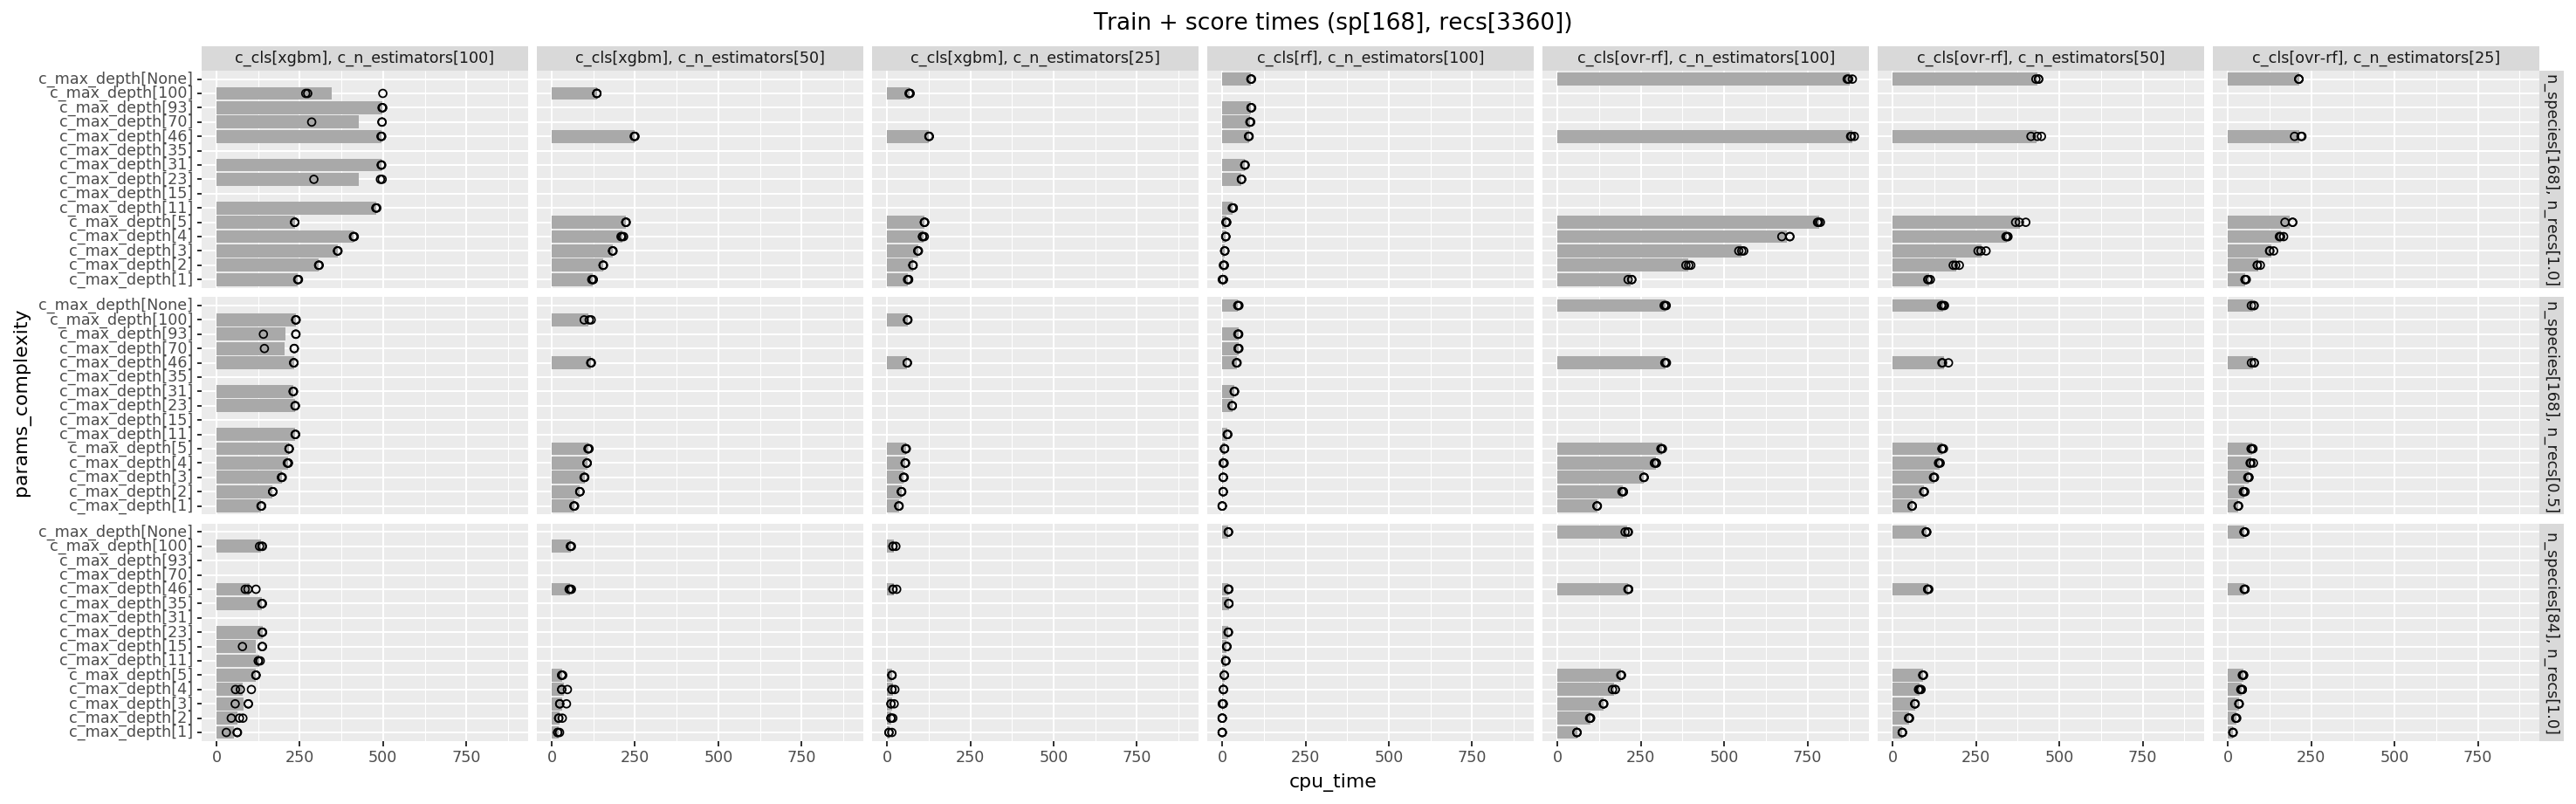

<ggplot: (-9223372036381118681)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(cpu_total_mean=lambda df: df.cpu_time.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_col(aes(y='cpu_total_mean'), fill='darkgray', position=position_dodge())
    + geom_point(aes(y='cpu_time'), color='black', fill='none', size=2)
    + coord_flip()
    + ylab('cpu_time')
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Train + score times ({recs_stats})')
)

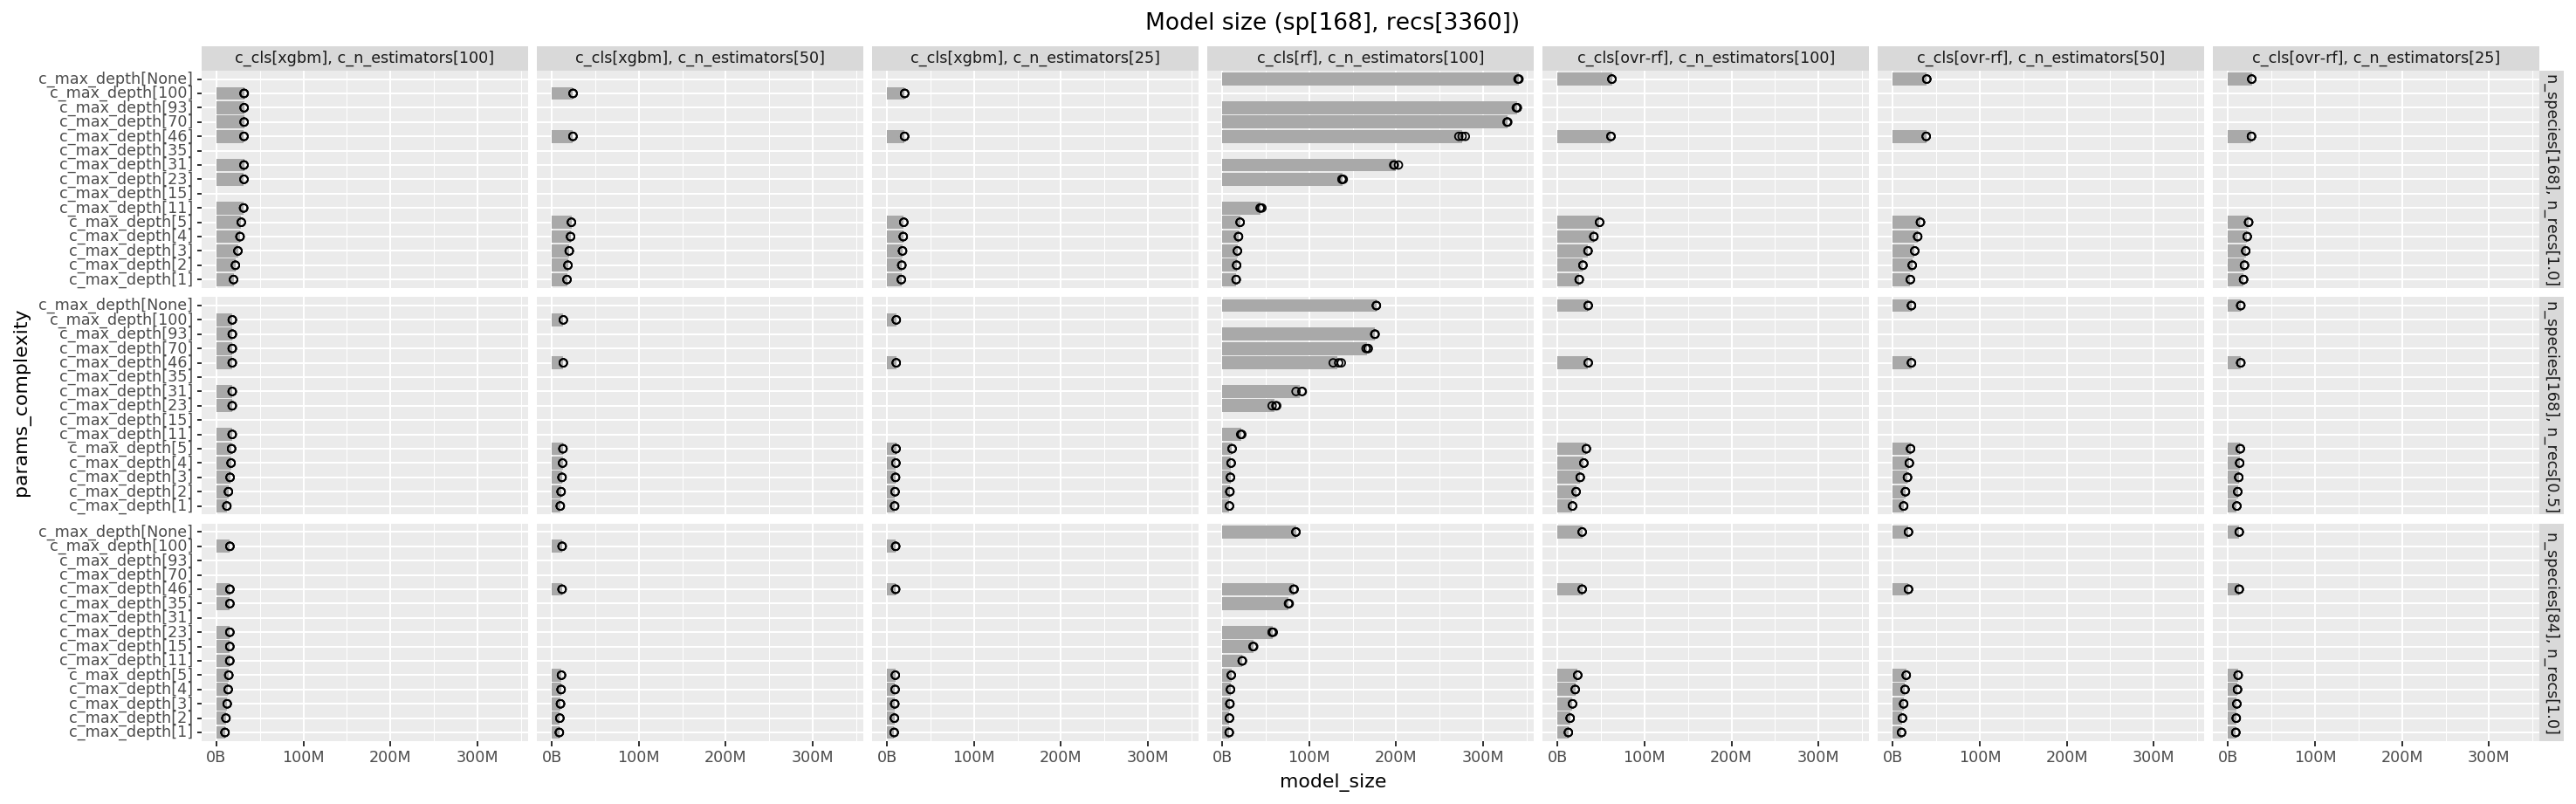

<ggplot: (562013718)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_col(aes(y='model_size_mean'), fill='darkgray', position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), color='black', fill='none', size=2) # Distribution of folds
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + coord_flip()
    + ylab('model_size')
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Model size ({recs_stats})')
)

In [ ]:
# Forest depth stats so we can tune max_depth, model_size
#   - TODO Generalize for models other than tree ensembles
cv_models = (cv_models
    .assign(
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
)
display(
    # cv_models[['model_id', 'forest_depth_mean', 'forest_depth_std']][:5],
)

In [ ]:
# TODO TODO Make not barf on non-tree models (blocks rest of notebook)
(cv_models
    # Manually compute boxplot stats, else it's _really_ slow (or you have to downsample, which misses outliers)
    #   - Based on stat_boxplot.compute_group
    .merge(how='left', on='params', right=cv_models.groupby('params').apply(lambda g: one(
        pd.Series(dict(
            params=g.name,
            ymin=boxplot['whislo'],
            lower=boxplot['q1'],
            middle=boxplot['med'],
            upper=boxplot['q3'],
            ymax=boxplot['whishi'],
            outliers=np.unique(boxplot['fliers']),  # np.unique else really slow, because lots of repeated (int) points
        ))
        for [boxplot] in [mpl.cbook.boxplot_stats(  # [boxplot] is 1 elem because X.ndim = 1
            X=np.concatenate([[] if x is None else x.depth for x in g.model_stats]),
            whis=1.5,
        )]
    )))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_boxplot(
        stat='identity',
        outlier_size=.5,
        mapping=aes(ymin='ymin', ymax='ymax', upper='upper', lower='lower', middle='middle', outliers='outliers',
            width=.8,  # Close enough to geom_boxplot defaults [TODO Maybe should compute based on num categorical x's?]
        ),
    )
    + ylab('tree_depth')
    + coord_flip()
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Tree depth ({recs_stats})')

)

[skip]

In [ ]:
# XXX Revive if insightful
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .assign(n_species=lambda df: df.params_dict.str['n_species'])
    .pipe(ggplot, aes(x='n_species', y='forest_depth_mean', color='params_no_ns'))
    # + facet_wrap('params_no_ns', ncol=2)
    + geom_point()
    + geom_pointrange(aes(ymin='forest_depth_mean - 2*forest_depth_std', ymax='forest_depth_mean + 2*forest_depth_std'))
    + geom_smooth(method='lm', se=False)  # Disable se because it only knows forest_depth_mean, no measure of spread
    + expand_limits(x=0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(aspect_ratio=1/3)
    + theme_figsize(aspect_ratio=1/3)
    + ggtitle(f'RF depth vs. n_species ({recs_stats})')
)

[skip]

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(mem_rss_delta_mean=lambda df: df.mem_rss_delta.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='mem_rss_delta_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='mem_rss_delta'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Mem rss spread ($max-min$) ({recs_stats})')
)

[skip]

In [ ]:
# TODO Might need to stack/geom_area for overlapping runs
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='cpu_system'), linetype='dashed', size=.5)
    + geom_line(aes(y='cpu_system + cpu_user'), linetype='solid', size=.5)
    + expand_limits(y=0)
    + ylab('cpu')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=lambda labels: ['%.3g%%' % x for x in labels])
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('cpu over time (system + user)')
)

[skip]

In [ ]:
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='mem_rss'), linetype='solid', size=.5)
    + geom_line(aes(y='mem_vms'), linetype='dashed', size=.5)
    + expand_limits(y=0)
    + ylab('mem')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes(pow=3))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('Mem over time (rss, vms)')
)

[skip]

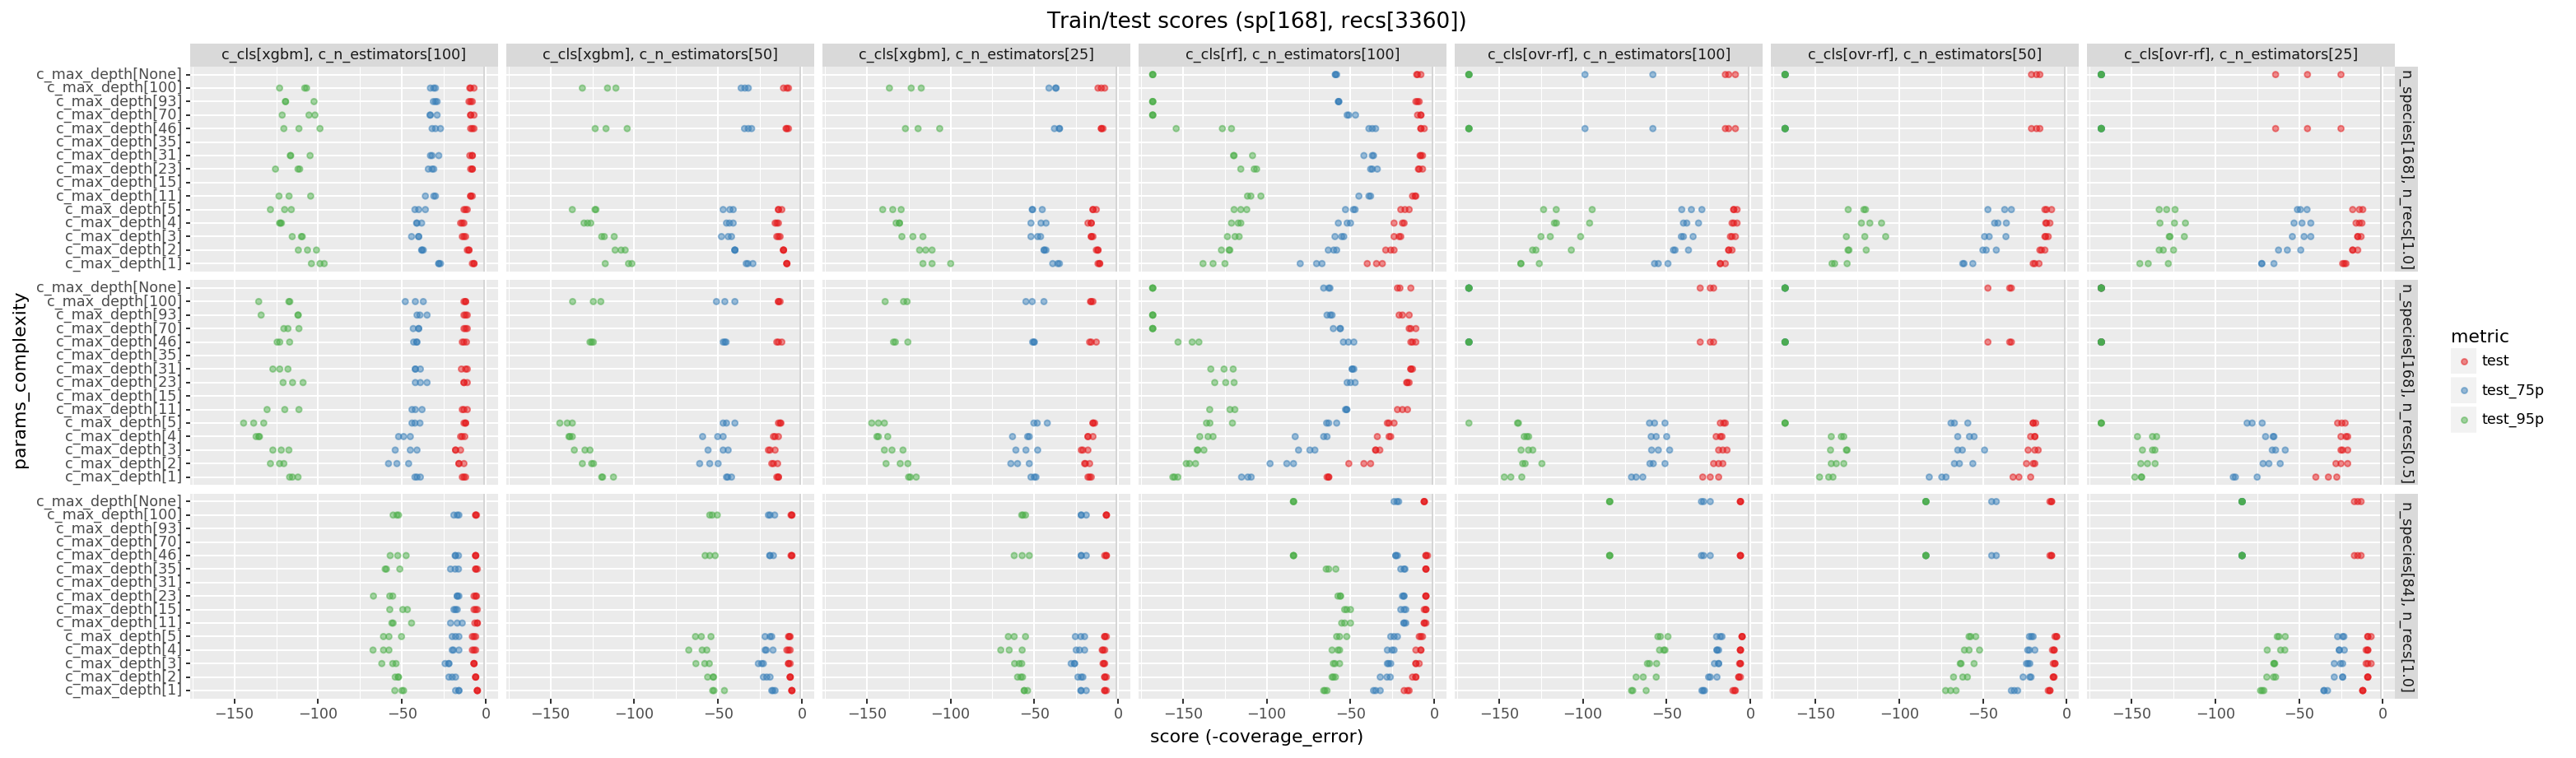

<ggplot: (-9223372036533609626)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(lambda df: pd.melt(df,
        id_vars=['params_data', 'params_model', 'params_complexity', 'params', 'fold'],
        value_vars=[
            # 'train_score',  # Boring
            'test_score',
            'test_75p_score',
            'test_95p_score',
        ],
        var_name='metric',
        value_name='score'),
    )
    .assign(
        metric=lambda df: df.metric.str.replace('_score', ''),
        group=lambda df: df.params_complexity.str.cat(df.metric, '/'),
    )
    .pipe(df_ordered_cat,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(ggplot)
    + aes(x='params_complexity')
    + aes(y='score')
    + aes(color='metric')
    + facet_grid('params_data ~ params_model')
    + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
    + geom_point(alpha=.5)
    # + geom_jitter(fill='none', size=3, height=1e-9, width=.05)
    # + geom_count(aes(size='..n..')) + scale_size_area()
    # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + coord_flip(
        # ylim=(-30, 0),
    )
    # + scale_color_cmap_d('tab10')
    + scale_color_cmap_d('Set1')
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ylab('score (-coverage_error)')
    + ggtitle(f'Train/test scores ({recs_stats})')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 32 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


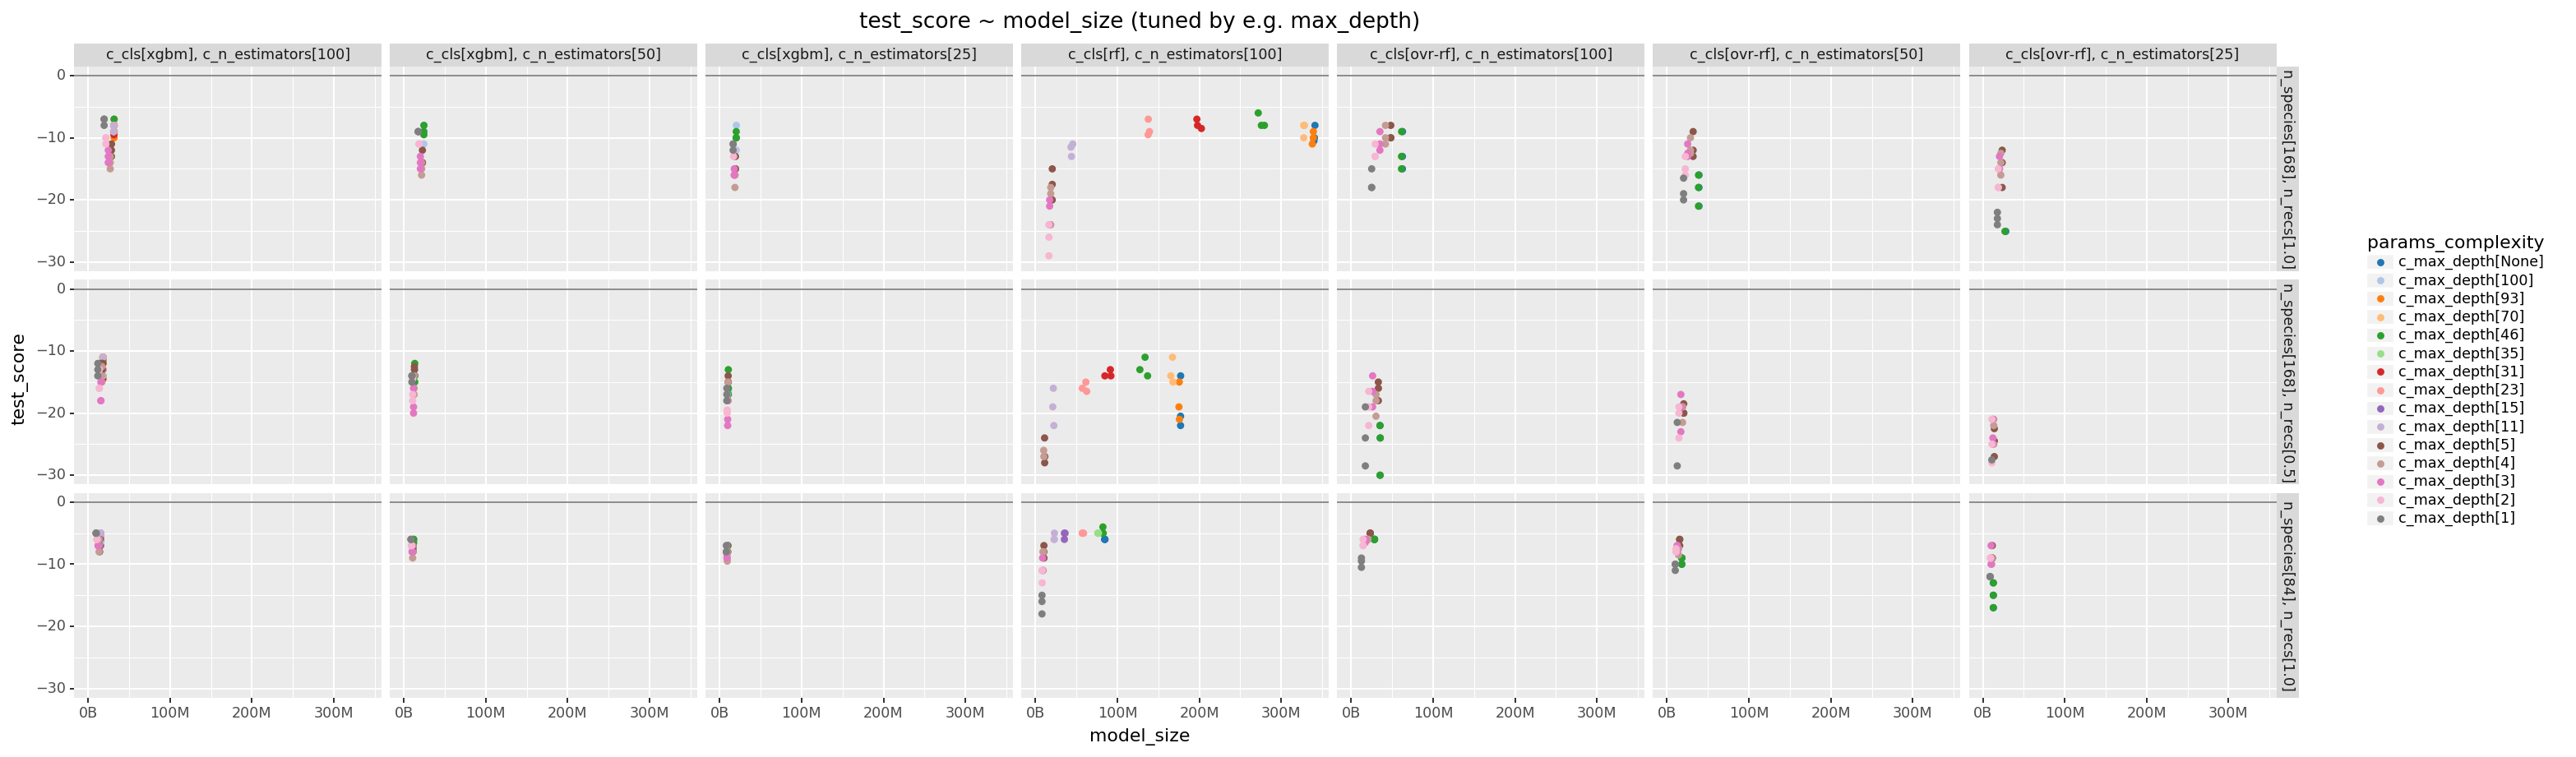

<ggplot: (-9223372036287900363)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='model_size', y='test_score')
    + aes(color='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ model_size (tuned by e.g. max_depth)')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 32 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


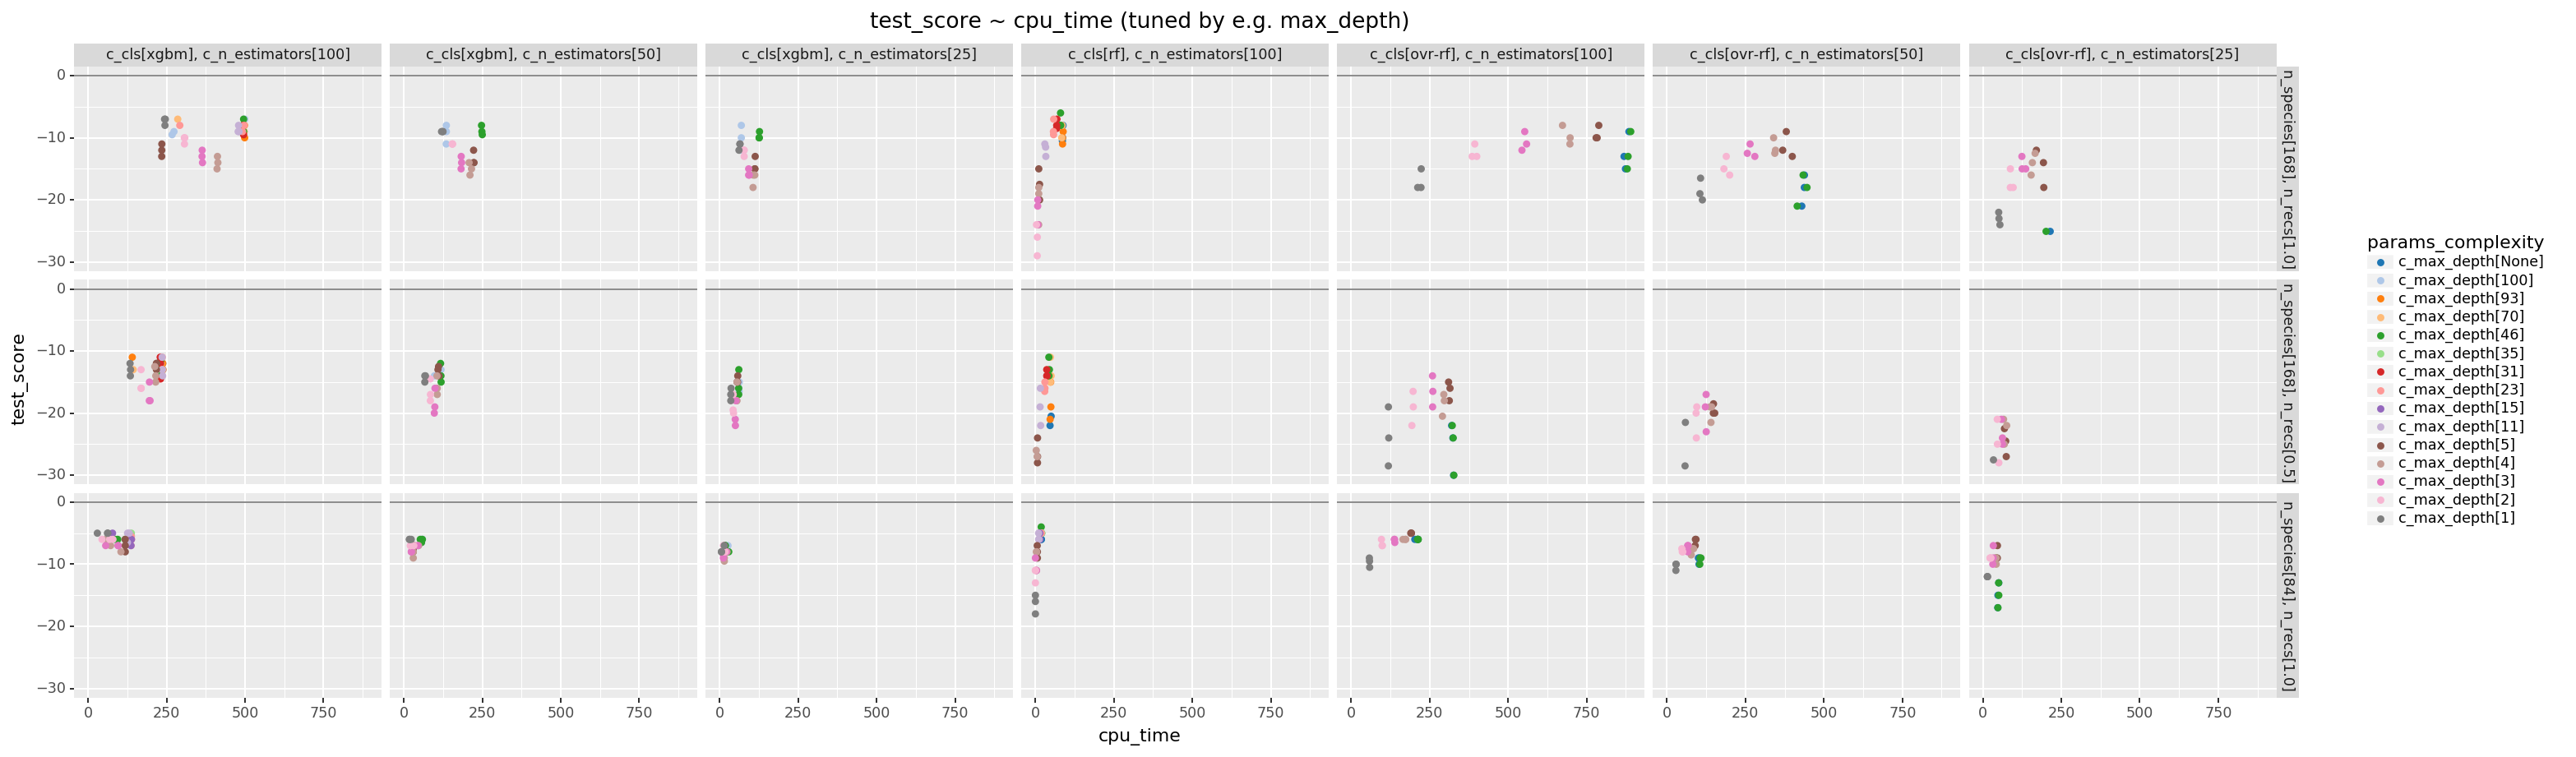

<ggplot: (-9223372036554330003)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='cpu_time', y='test_score')
    + aes(color='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    # + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ cpu_time (tuned by e.g. max_depth)')
)

In [ ]:
SLOW_PLOTS_NEXT

NameError: name 'SLOW_PLOTS_NEXT' is not defined

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(cv_models.params.cat.categories))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            params_data=row.params_data,
            params_model=row.params_model,
            params_complexity=row.params_complexity,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
    .astype(dict(
        model_id=cv_models.model_id.dtype,
        params=cv_models.params.dtype,
        params_data=cv_models.params_data.dtype,
        params_model=cv_models.params_model.dtype,
        params_complexity=cv_models.params_complexity.dtype,
    ))
    .pipe(tap, lambda df: display(
        df_summary(df).T,
        df[:10],
    ))
)

In [ ]:
params_data = 'n_species[168], n_recs[1.0]'
n_species = parse.search('n_species[{n_species:d}], n_recs[{n_recs:f}]', params_data)['n_species']

In [ ]:
# Facet by params_no_ns, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    # .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
    )
    .pipe(ggplot)
    + aes(x='y_true', y='coverage_error')
    + aes(color='y_true')
    + facet_grid('params_complexity ~ params_model')
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with n_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + theme_minimal()  # Before other theme()
    + guides(color=guide_legend(nrow=70))
    + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8, legend_text=element_text(size=8))
    + theme(axis_text_y=element_blank())
    + theme_figsize(width=12, aspect_ratio=1/2)
    + ggtitle(rf'Coverage error over fold $\times$ instance ({recs_stats}) [{params_data}]')
)

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
# params_model = 'c_cls[rf], c_n_estimators[100]'
params_model = 'c_cls[logreg_multi], c_solver[newton-cg]'
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_model == params_model]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity', y='coverage_error')
    + aes(color='params_complexity')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    # + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab10'))  # Strong
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=24, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_complexity ({recs_stats}) [{params_data}, {params_model}]')
)

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
# params_complexity = 'c_max_depth[46]'
params_complexity = ''
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_complexity == params_complexity]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'params_model')
    .pipe(ggplot)
    + aes(x='params_model', y='coverage_error')
    + aes(color='params_model')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    + scale_color_cmap_d('tab10')  # Strong
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=24, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_model ({recs_stats}) [{params_data}, {params_model}]')
)

In [ ]:
ONE_MODEL_PLOTS_NEXT

# Model diagnostics: one model, all folds

In [ ]:
params_i = 0
params = cv_models.params.cat.categories[params_i]
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), params))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:5],
)

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=10, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance ({params}) ({recs_stats})')
)

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = cv_models.params.cat.categories[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]